In [1]:
import numpy as np 
#import os
#import skimage.io as io
#import skimage.transform as trans
#import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler ,EarlyStopping
from keras import backend as keras
from keras.metrics import *
from keras.losses import *
from keras import models
#from tensorflow.keras import layers
from sklearn.metrics import classification_report

#custom
import tensorflow as tf

#from new tutorial
#from tensorflow import keras
import numpy as np
#from tensorflow.keras.preprocessing.image import load_img

'''import random
import cv2
import tifffile as tiff

from PIL import Image ,ImageOps'''

#import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator

import math
from datetime import datetime

##beginning of others
from tensorflow.keras.utils import Sequence , get_file

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler ,EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras

#%env SM_FRAMEWORK=tf.keras
#import segmentation_models as sm
#sm.set_framework('tf.keras')

'''os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"]= "32"
tf.config.threading.set_intra_op_parallelism_threads(32)
tf.config.threading.set_inter_op_parallelism_threads(2)'''

from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

In [2]:
def Timenow(prt=False):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [4]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

image_shape = (512,512,3)
# Build model
#model_andor_weight_path = "/home/hgamarro/DeepLearning/JB_space/models/Unet/"
model_andor_weight_path = "/mnt/hgfs/VMsharedFolder/git/final-project-landandbuildingsatimg-ccny/models/pix2pix/"

if os.path.isdir(model_andor_weight_path) & False:
    gan_model = keras.models.load_model(model_andor_weight_path+'model_unet6_base.h5')
    gan_model.load_weights(model_andor_weight_path+'weights_unet5_e02.h5')
    gan_model.summary()
    print("loaded model from file")
else:
    # define image shape
    # define the models
    d_model = define_discriminator(image_shape)
    g_model = define_generator(image_shape)
    # define the composite model
    gan_model = define_gan(g_model, d_model, image_shape)
    # summarize the model
    gan_model.summary()
    # plot the model
    print("loaded model from code")
    
gan_model.save(model_andor_weight_path+"model_gan1.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 512, 512, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 32, 32, 1)    6968257     input_4[0][0]                    
                                                                 model_1[0][0]                    
Total params: 61,397,572
Trainable params: 54,422,275
Non-trainable params: 6,975,297
__________________________________________________________________________________________________
loaded

In [14]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path).astype('float32')
        return X, y

In [16]:

out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'


# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================
all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))
}
val_partition = [item for item in all_val_files if "image_file" in item]


train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

FileNotFoundError: [Errno 2] No such file or directory: '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train/images/'

In [15]:
#re ,inp = load(PATH+'train/100.jpg')
#flips mask and input image
re ,inp = train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
#val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

NameError: name 'partition' is not defined

In [12]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

NameError: name 'inp' is not defined

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [ ]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [ ]:
EPOCHS = 150

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
        checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
# example of defining a composite model for training the generator model

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

# define image shape
image_shape = (512,512,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [ ]:
# select a batch of real samples
[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

In [ ]:
# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

In [ ]:
# update discriminator for real samples
d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

In [ ]:
# update the generator
g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, n_patch=16):
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

In [ ]:
# load image data
dataset = ...
# train model
train(d_model, g_model, gan_model, dataset)

### beginning of local datagenerators

In [9]:
os.getcwd()

'/home/hgamarro/DeepLearning/JB_space/notebooks/scratch'

### beginning of server datagenerators

In [10]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path).astype('float32')
        return X, y    

In [11]:
out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'

In [12]:
# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================
all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))
}
val_partition = [item for item in all_val_files if "image_file" in item]

In [13]:
train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

### datagenerator proof of function

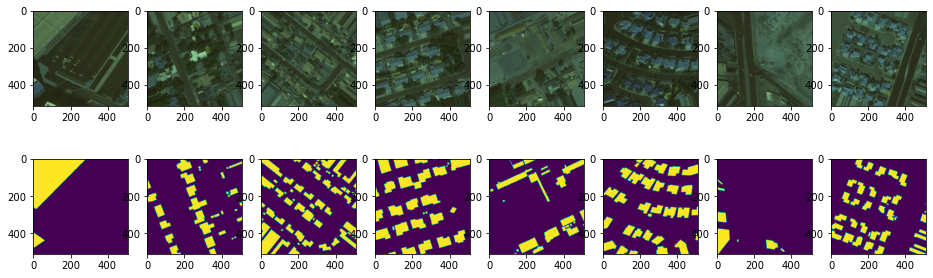

In [14]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = train_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[5][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [11]:
np.histogram(train_generator[22][0][a+5,:,:,:])

(array([ 23668, 275846, 331015, 109239,  35147,   8243,   1943,    901,
           259,    171]),
 array([0.00390991, 0.09049501, 0.17708011, 0.26366523, 0.35025033,
        0.4368354 , 0.5234205 , 0.6100056 , 0.6965907 , 0.7831758 ,
        0.86976093], dtype=float32))

In [12]:
print(np.histogram(train_generator[14][1][a+5,:,:,:]))

print(train_generator[14][1][a+5,:,:,:].dtype)

(array([223487,      0,      0,      0,      0,      0,      0,      0,
            0,  38657]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
float32


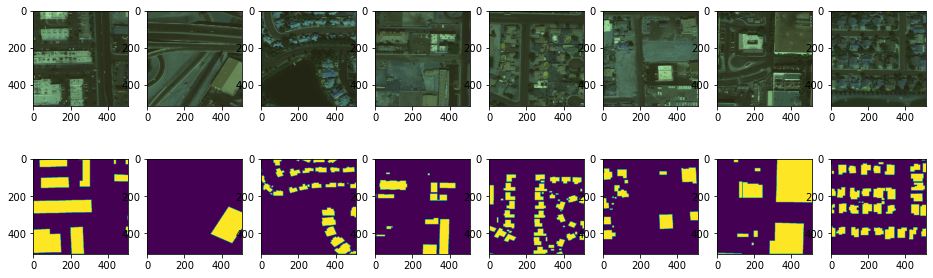

In [13]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = val_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = val_generator[5][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [ ]:
rng = image[layer_idx][0,:,:,channel_idx]
rng = rng.reshape(rng.shape[0]*rng.shape[1])
plt.hist(rng, bins='auto')
plt.show

In [14]:
np.histogram(val_generator[14][0][a+5,:,:,:])

(array([  8335, 177047, 297388, 194598,  80858,  18376,   6804,   2280,
           689,     57]),
 array([0.01176471, 0.09764706, 0.1835294 , 0.26941177, 0.3552941 ,
        0.44117647, 0.52705884, 0.6129412 , 0.6988235 , 0.7847059 ,
        0.87058824], dtype=float32))

In [15]:
print(np.histogram(val_generator[14][1][a+5,:,:,:]))

print(val_generator[14][1][a+5,:,:,:].dtype)

(array([202068,      0,      0,      0,      0,      0,      0,      0,
            0,  60076]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
float32


### model start

In [14]:
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
unet.compile(optim, total_loss, metrics)

# define callbacks for learning rate scheduling and best checkpoints saving

model_andor_weight_path = "/home/hgamarro/DeepLearning/JB_space/models/Unet/"
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = model_andor_weight_path+'best_weights_unet5_e{epoch:02d}.h5'
                                    ,save_freq = 'epoch'
                                    ,verbose = 1
                                    ,save_weights_only=True
                                    ,save_best_only=False
                                    ,mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

earlystop = EarlyStopping(monitor='iou_score'
                         ,min_delta = .01
                         ,patience=3)

In [ ]:
start = datetime.now()
print("start: " ,start)

history = unet.fit(
    train_generator, 
    steps_per_epoch=1, 
    epochs=EPOCHS, 
    callbacks=[callbacks, earlystop] 
    #validation_data=val_generator, 
    validation_steps=len(val_generator),
    use_multiprocessing=True
)

end = datetime.now()
print("end: " ,end)
print("\nTime Taken for testing: %s" % (end-start))

unet.save(model_andor_weight_path+"model_unet5.h5")

In [25]:
keras.backend.clear_session()

In [ ]:
get_layer(layer_name).outputs

In [119]:
#copies all layers of model
activation_layers = [layer.output for layer in unet.layers]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=unet.input, outputs=activation_layers)
# Returns a list of five Numpy arrays: one array per layer activation
print ("num of layers: " ,len(activation_layers))
activation_model.summary()

num of layers:  72
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________

In [12]:
datapath = "/mnt/hgfs/VMsharedFolder/git/misc"
x_path = "/npy"
y_path = "/masks"

input_imgs_path = datapath + x_path
target_imgs_path = datapath + y_path

x=[]
y=[]

#tempxx = np.load(datapath+'/image_file_14.npy')
#tempxx = np.load(datapath+'/label_file_14.npy')

input_img_paths = sorted(
    [
        os.path.join(input_imgs_path ,fname)
        for fname in os.listdir(input_imgs_path)
        if fname.endswith(".npy")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_imgs_path, fname)
        for fname in os.listdir(target_imgs_path)
        if fname.endswith(".npy") and not fname.startswith(".")
        
    ]
)

for npy in input_img_paths:
    x.append(np.load(npy))
    print(npy)

for npy in target_img_paths:
    y.append(np.load(npy))
    print(npy)
    
x = np.array(x)
y = np.array(y)
#x = x [: ,:512 ,:512 ,:]
#y = y[: ,:512 ,:512]

#img_size = x_train[0][0].shape
print(x.shape)
print(y.shape)

/mnt/hgfs/VMsharedFolder/git/misc/npy/image_file_14.npy
/mnt/hgfs/VMsharedFolder/git/misc/npy/image_file_84.npy
/mnt/hgfs/VMsharedFolder/git/misc/masks/label_file_14.npy
/mnt/hgfs/VMsharedFolder/git/misc/masks/label_file_84.npy
(2, 32, 512, 512, 3)
(2, 32, 512, 512, 1)


In [13]:
print(x[0][4].shape)
print(y[0][4].shape)

(512, 512, 3)
(512, 512, 1)


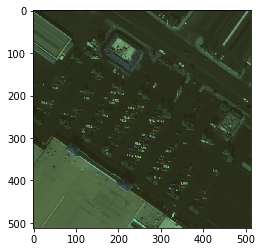

In [14]:
plt.imshow(x[0][4])

In [15]:
print(y[0].shape)
print(y[0][:2].shape)
print(y[0][4 ,: ,: ,0].shape)

(32, 512, 512, 1)
(2, 512, 512, 1)
(512, 512)


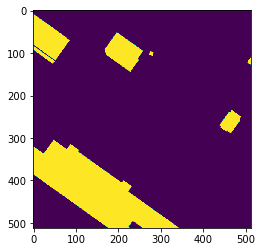

In [16]:
plt.imshow(y[0][4 ,: ,: ,0])

(512, 512, 3)
temp1 (1, 512, 512, 3)
pred2 (1, 512, 512, 1)
pred3 (512, 512, 1)


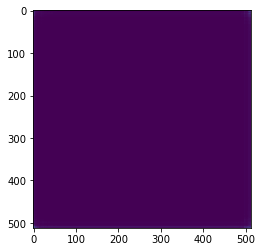

In [115]:
idx = 30
temp = x[0][idx ,: ,: ,:]
print(temp.shape)
#temp = np.expand_dims(x[idx] ,axis=0)
#temp = x_train[idx]
temp = np.expand_dims(temp ,axis=0)
print("temp1" ,temp.shape)

def axis_i(arr, axis, i):
    idx = (np.s_[:],) * axis + (i,)
    return arr[idx]

temp_pred = np.array(unet.predict(temp))
#temp_pred = activation_model.predict(temp)
print("pred2" ,temp_pred.shape)
temp_pred = axis_i(temp_pred ,0 ,0)
print("pred3" ,temp_pred.shape)

#print(temp_pred)
#for i in np.arange(0 ,temp_pred[-1].shape[1]):
    #plt.figure().add_subplot(1 ,2 ,i+1)
plt.imshow(temp_pred[:,:,i])

# of layers  72

pred shape: (1, 256, 256, 32)
conv2d_transpose_7


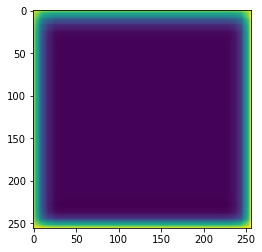

In [121]:
#proving that the model has been copied over
# Returns a list of arrays: one array per layer activation
temp_pred = activation_model.predict(temp)
print("# of layers " ,len(temp_pred))

# One activation layer example as numpy array
layer_idx = 65
print("\npred shape:" ,temp_pred[layer_idx].shape)
channel_idx = 0
plt.imshow(temp_pred[layer_idx][0,:,:,channel_idx] )
print(activation_model.layers[layer_idx].name)

<function matplotlib.pyplot.show(*args, **kw)>

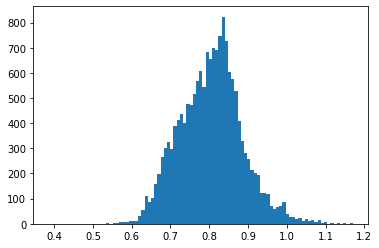

In [94]:
rng = temp_pred[layer_idx][0,:,:,channel_idx]
rng = rng.reshape(rng.shape[0]*rng.shape[1])
plt.hist(rng, bins='auto')
plt.show

In [ ]:
del rng

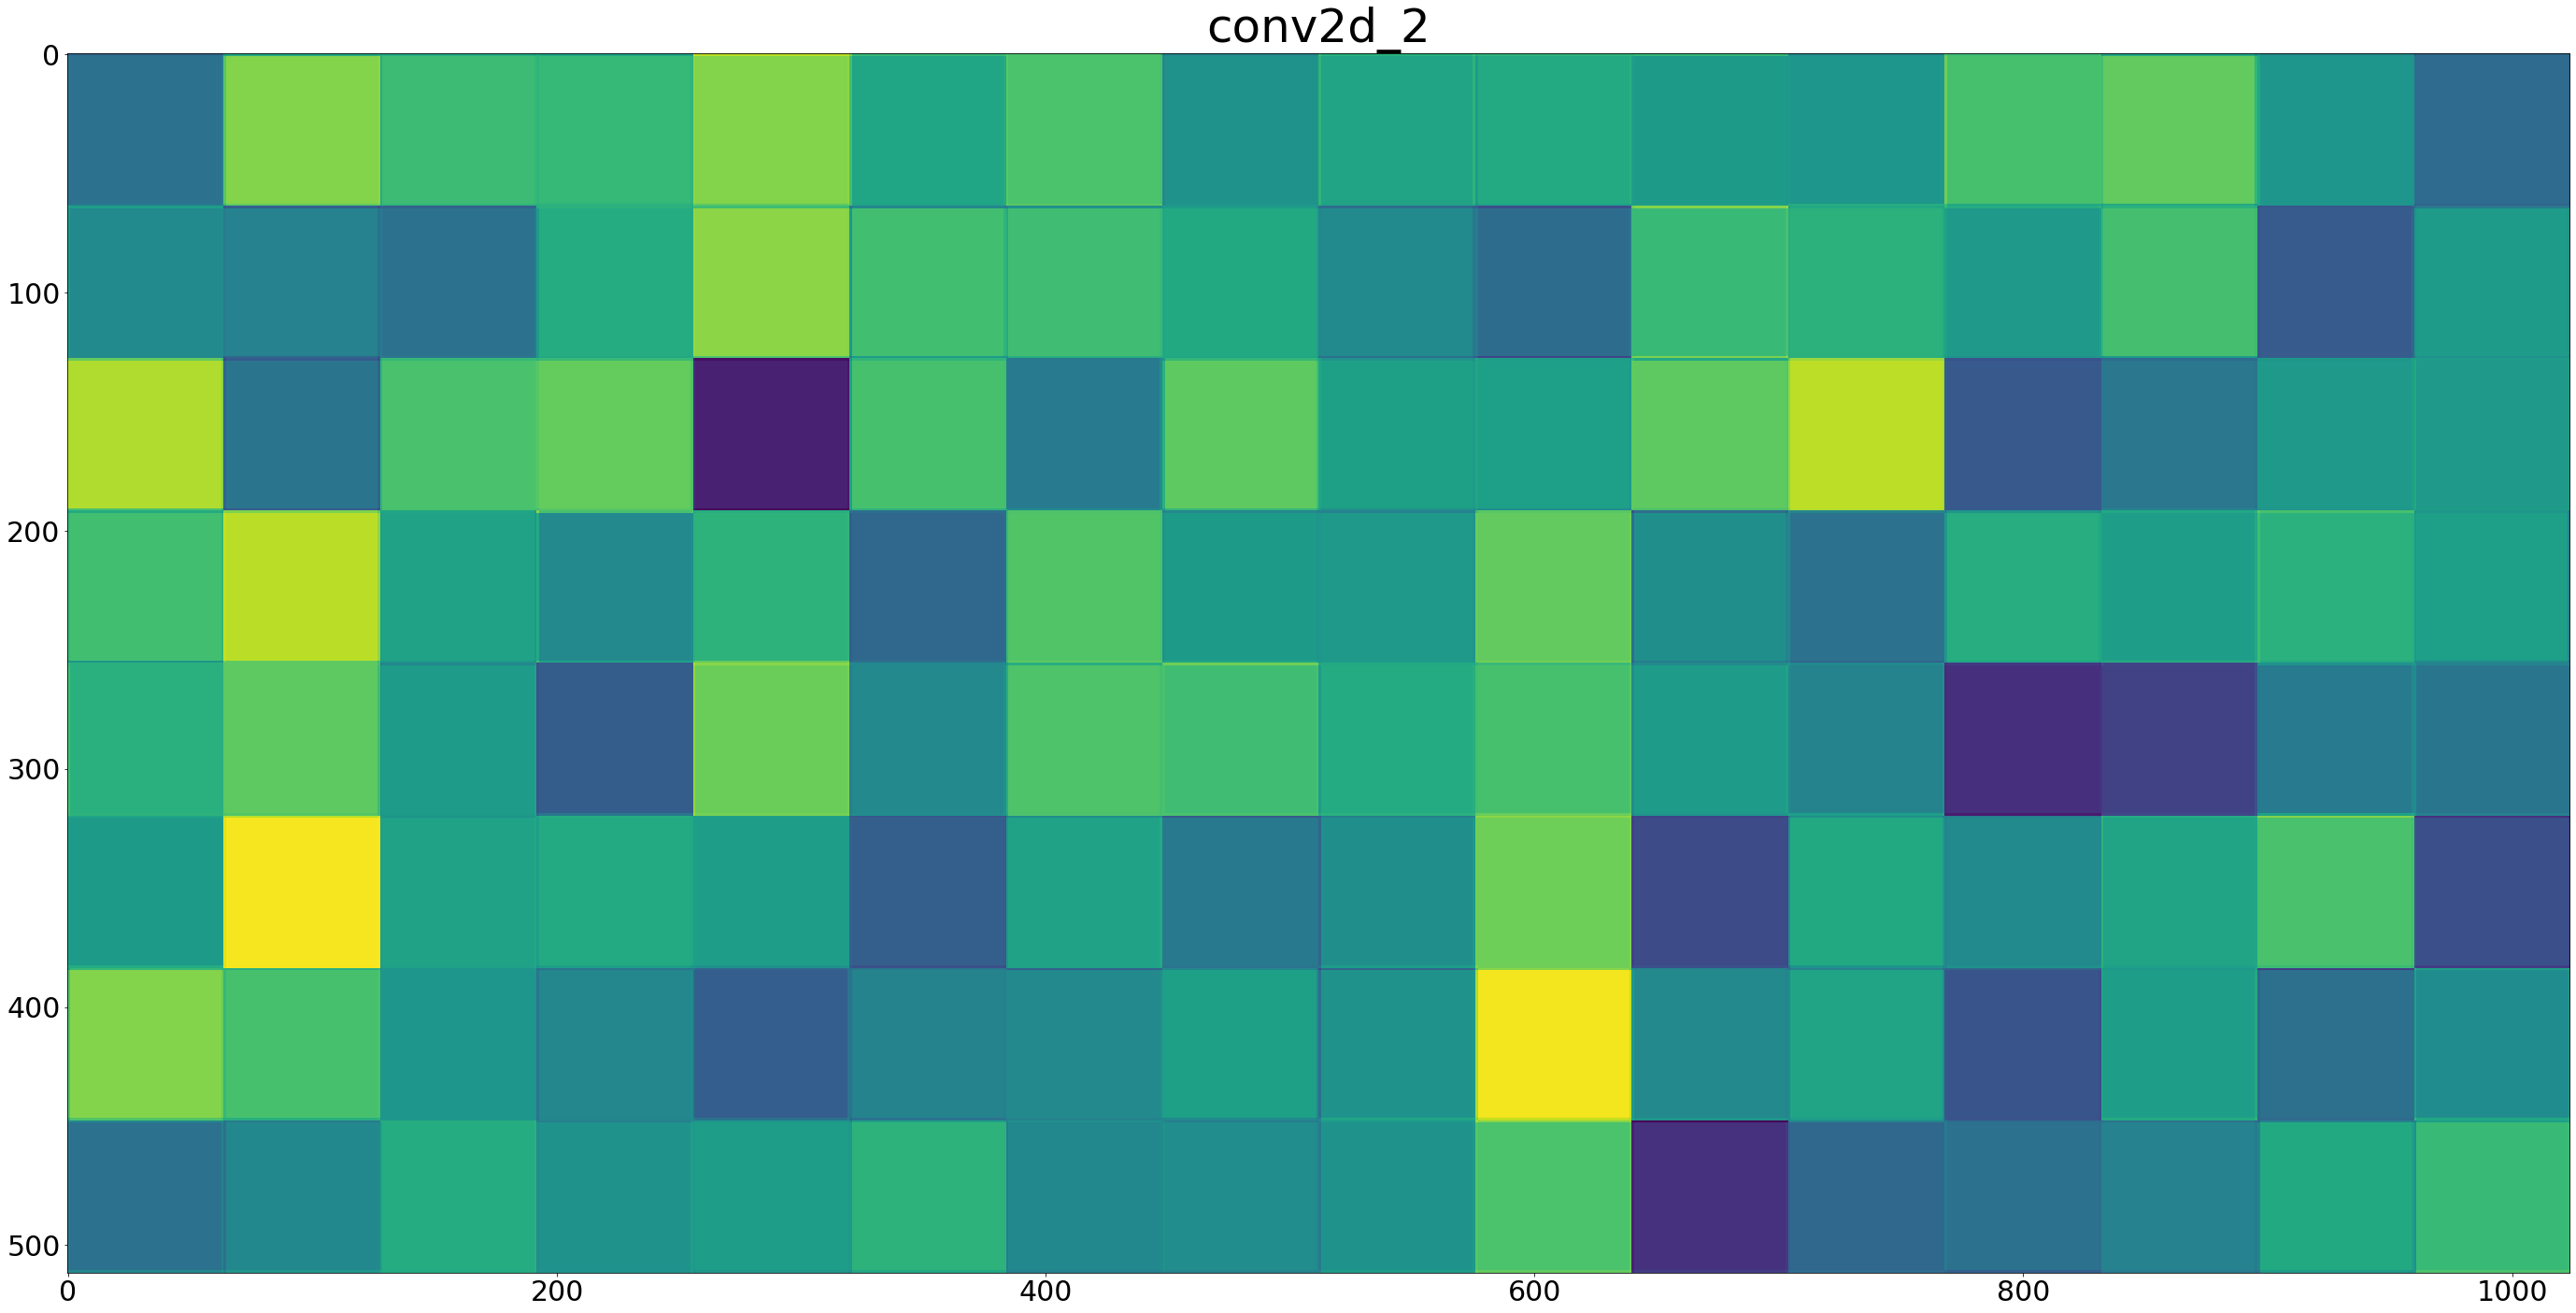

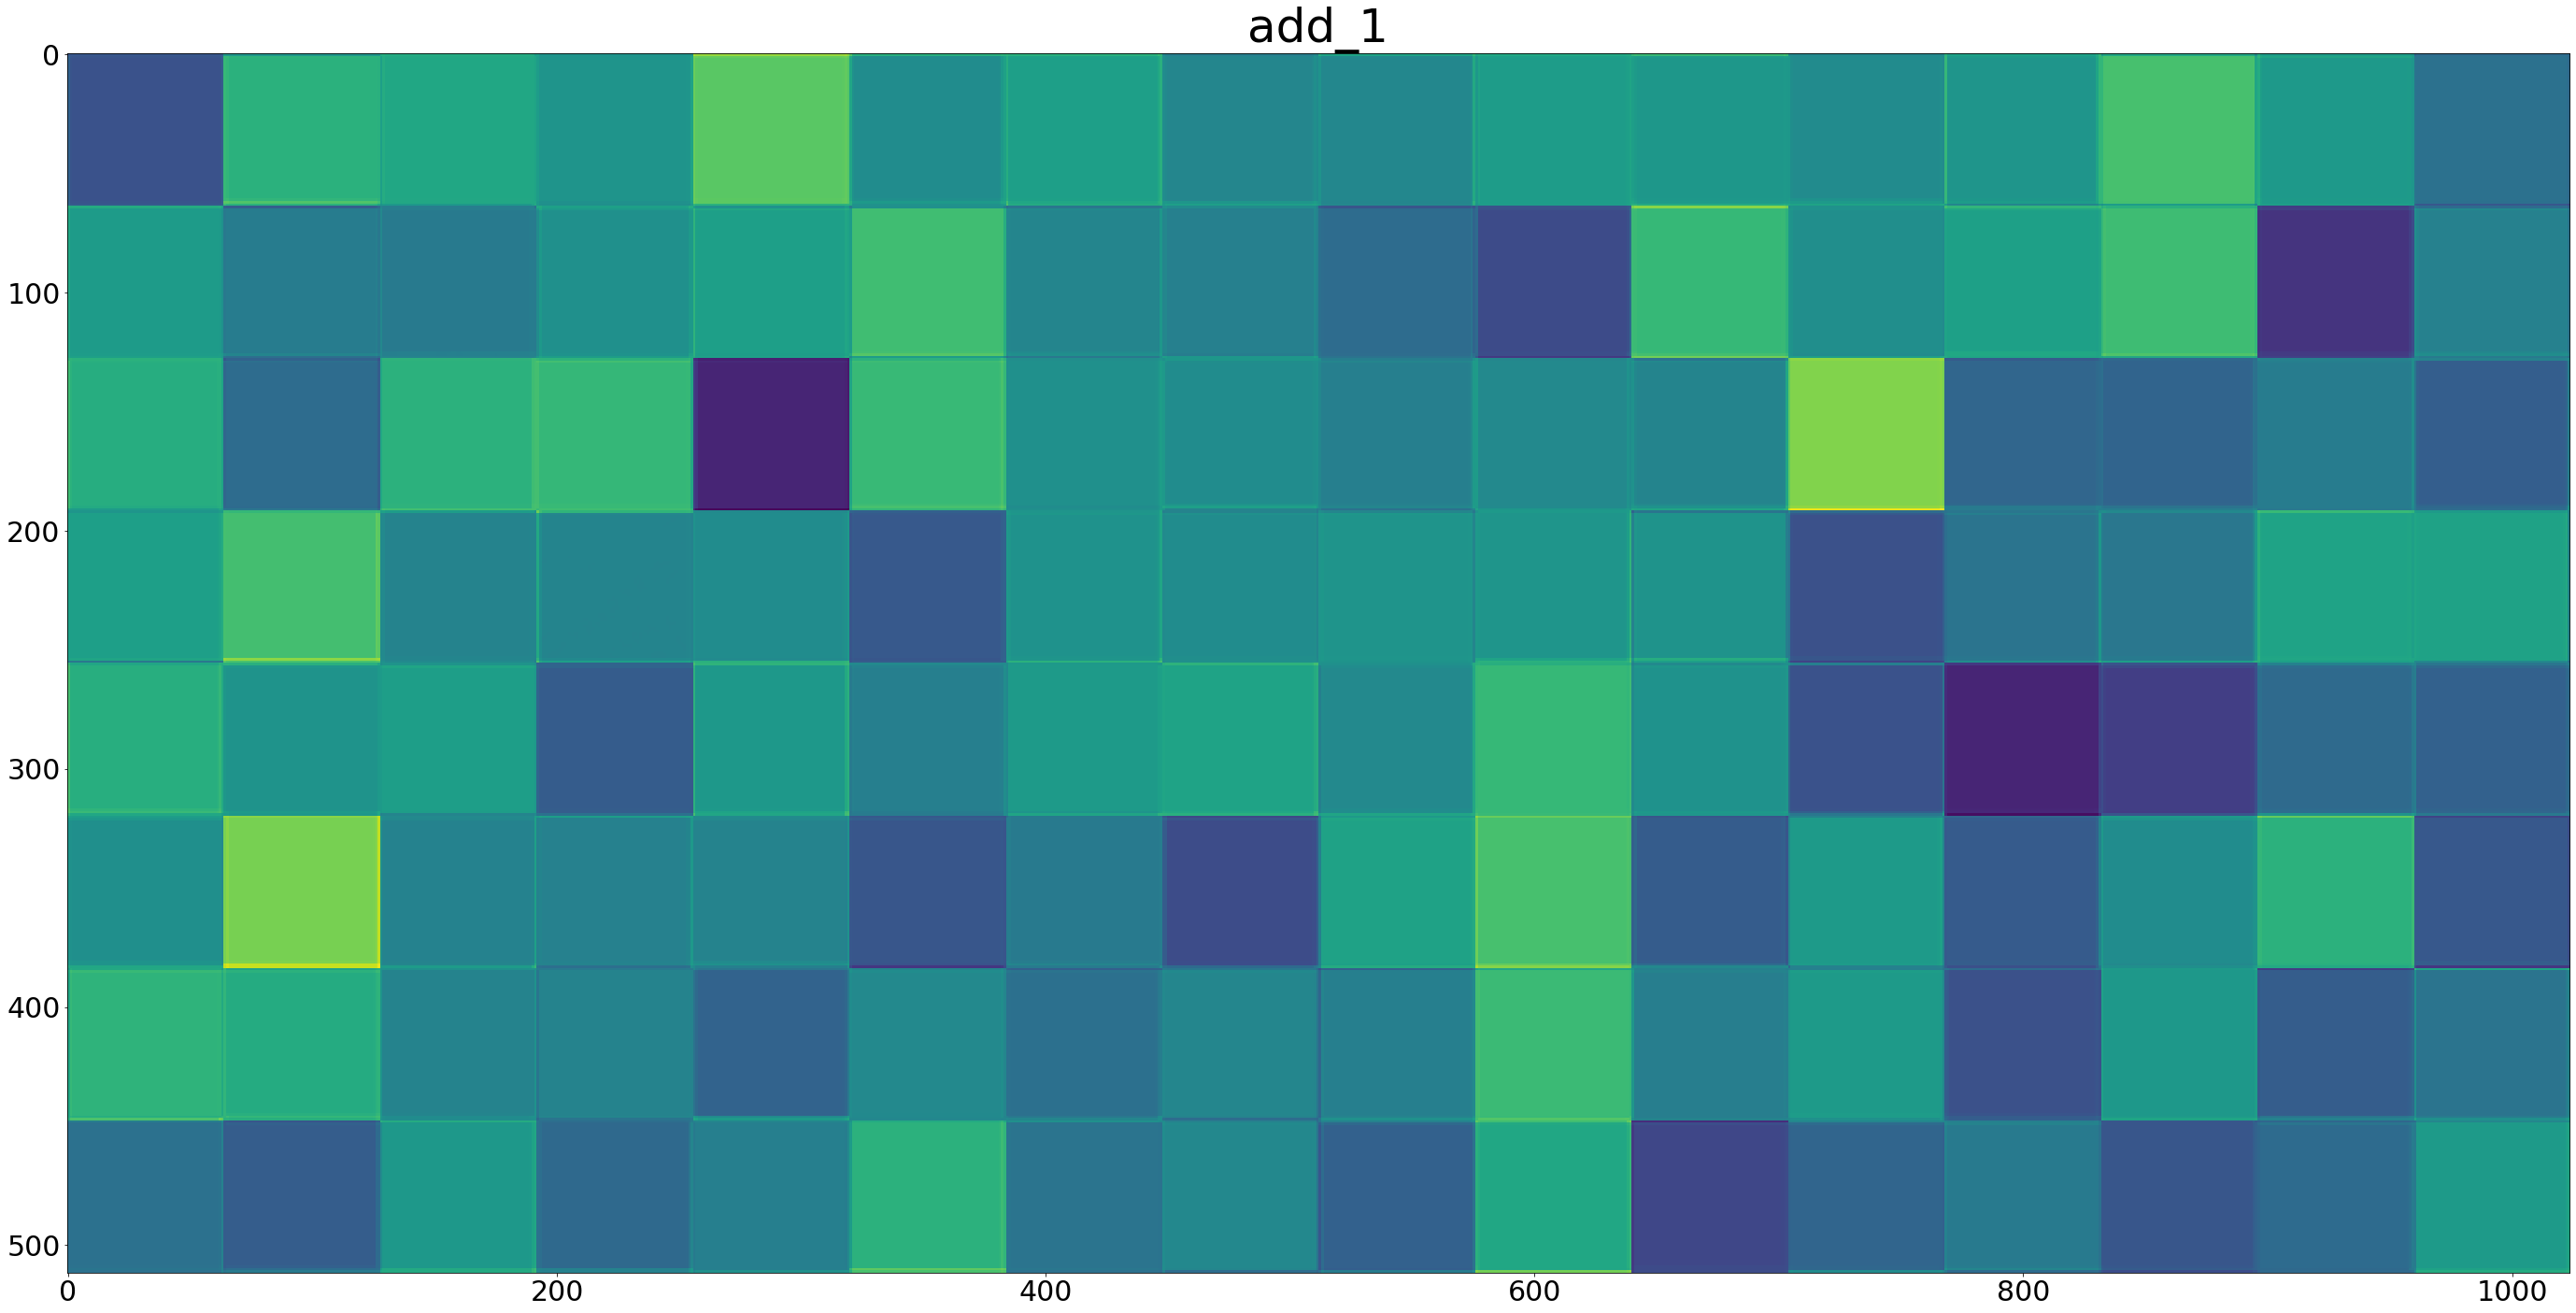

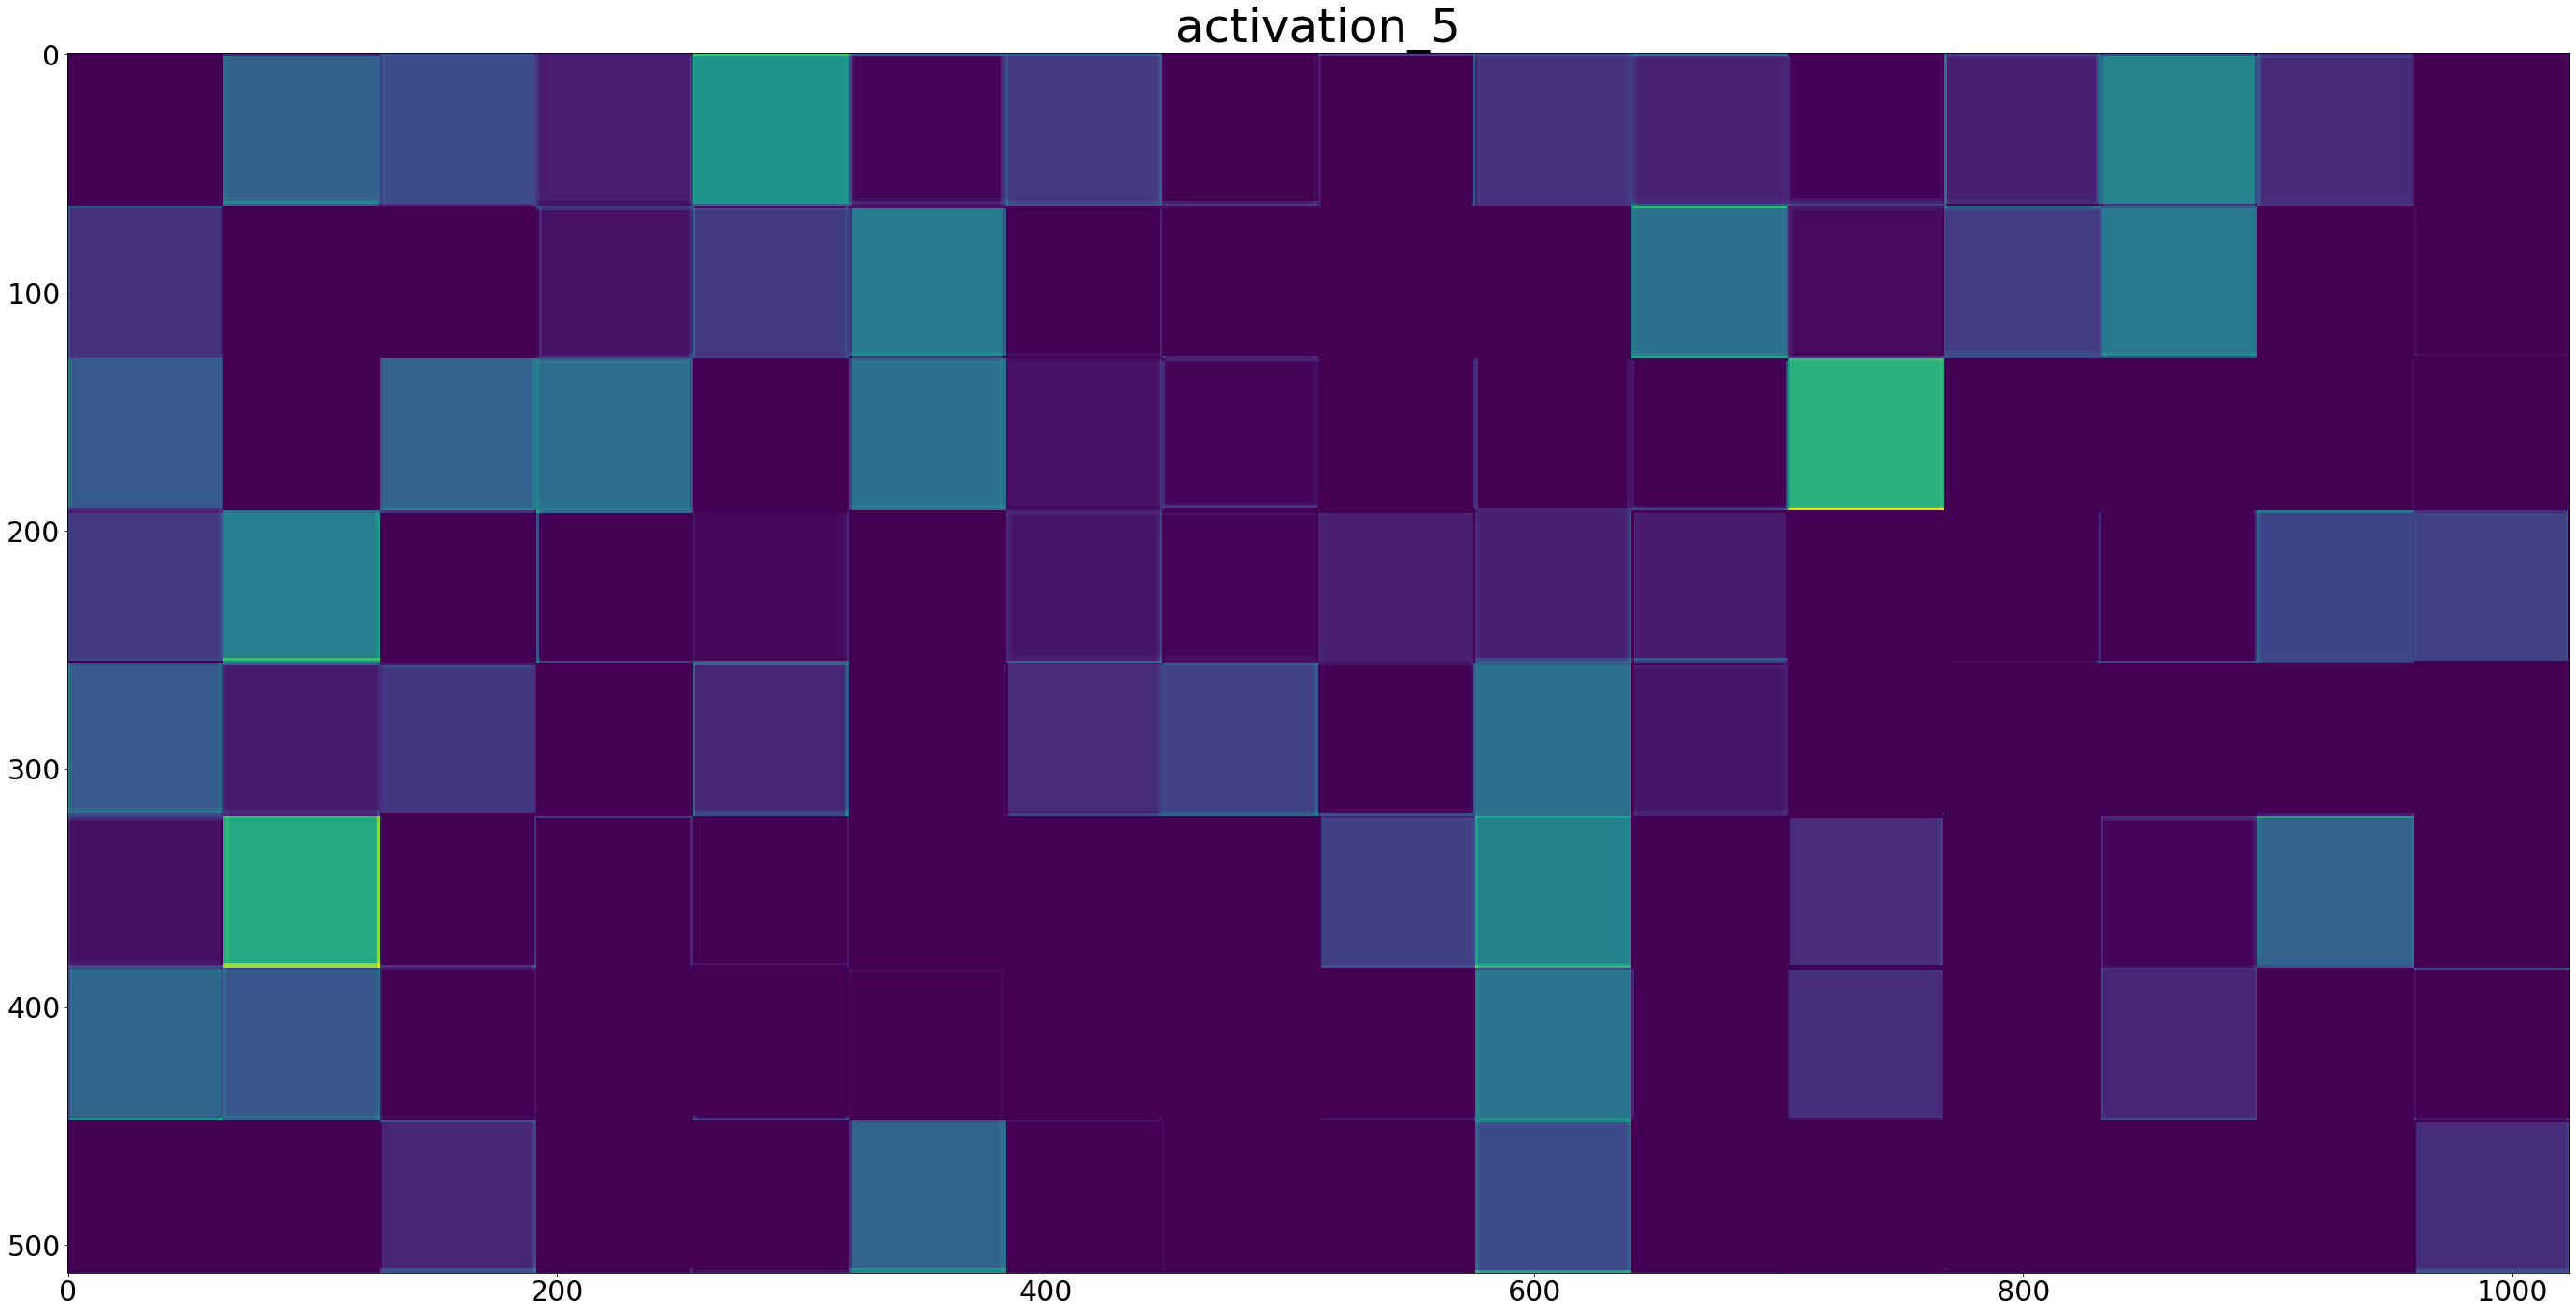

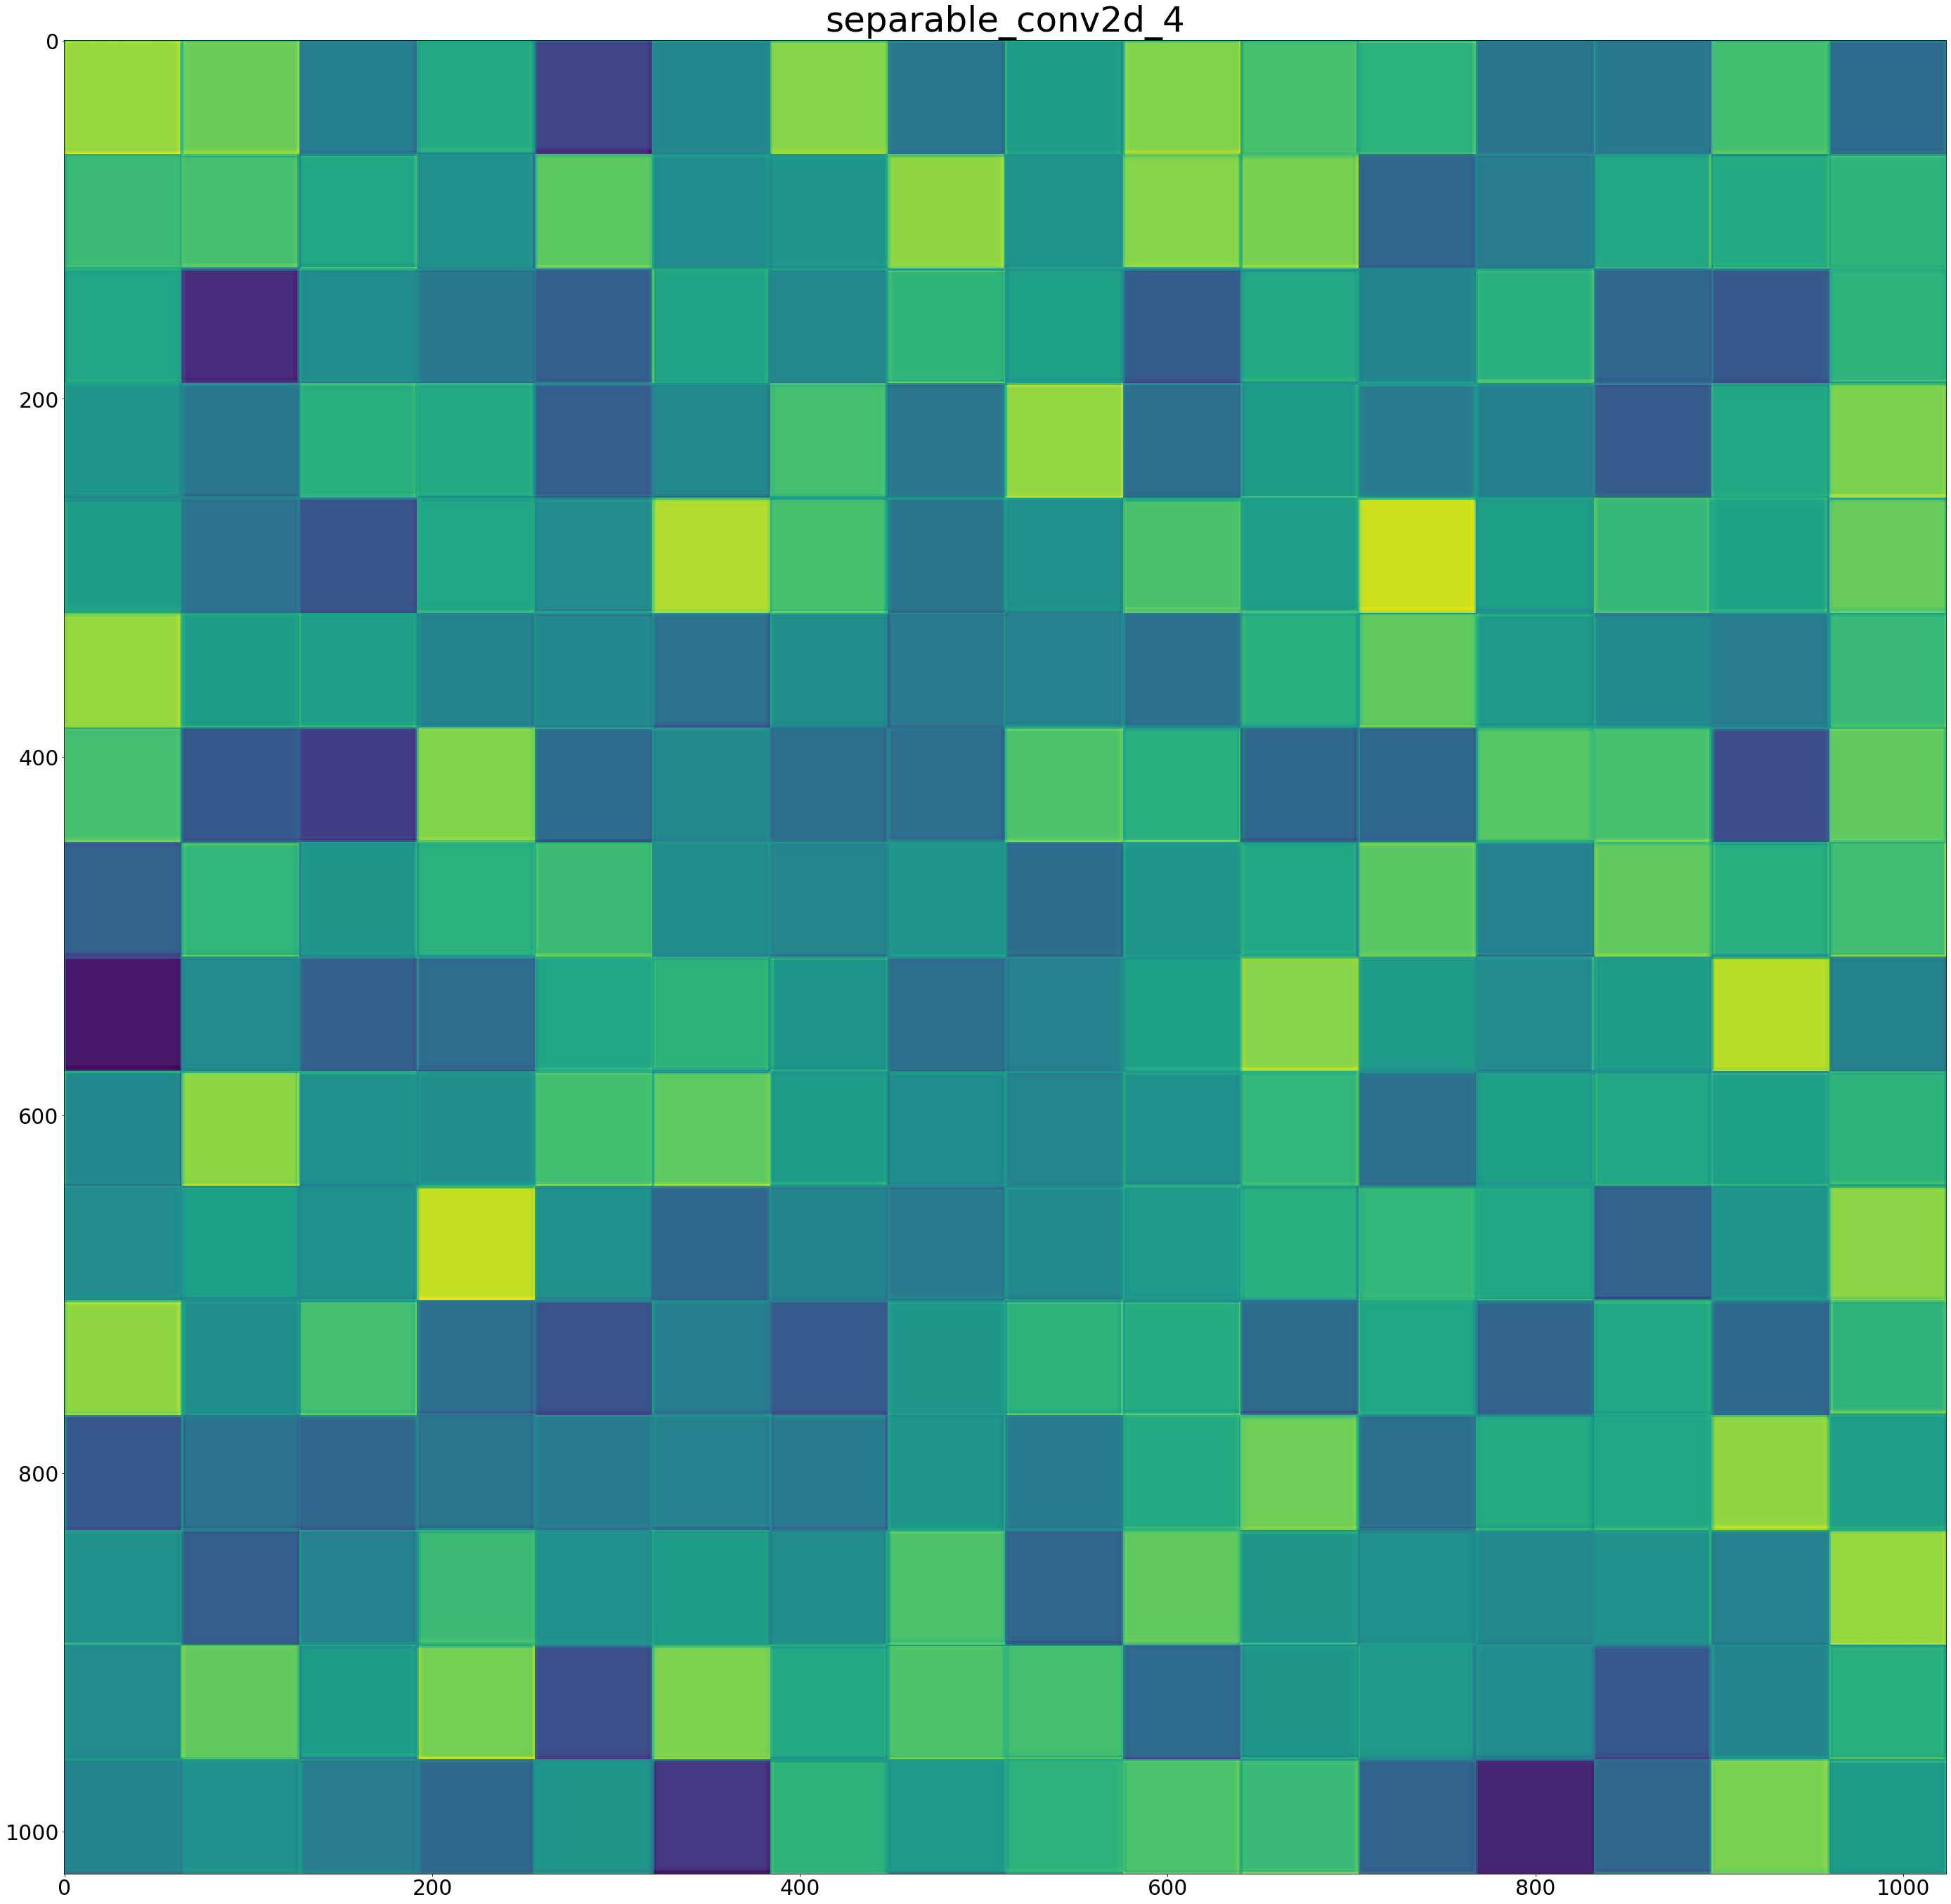

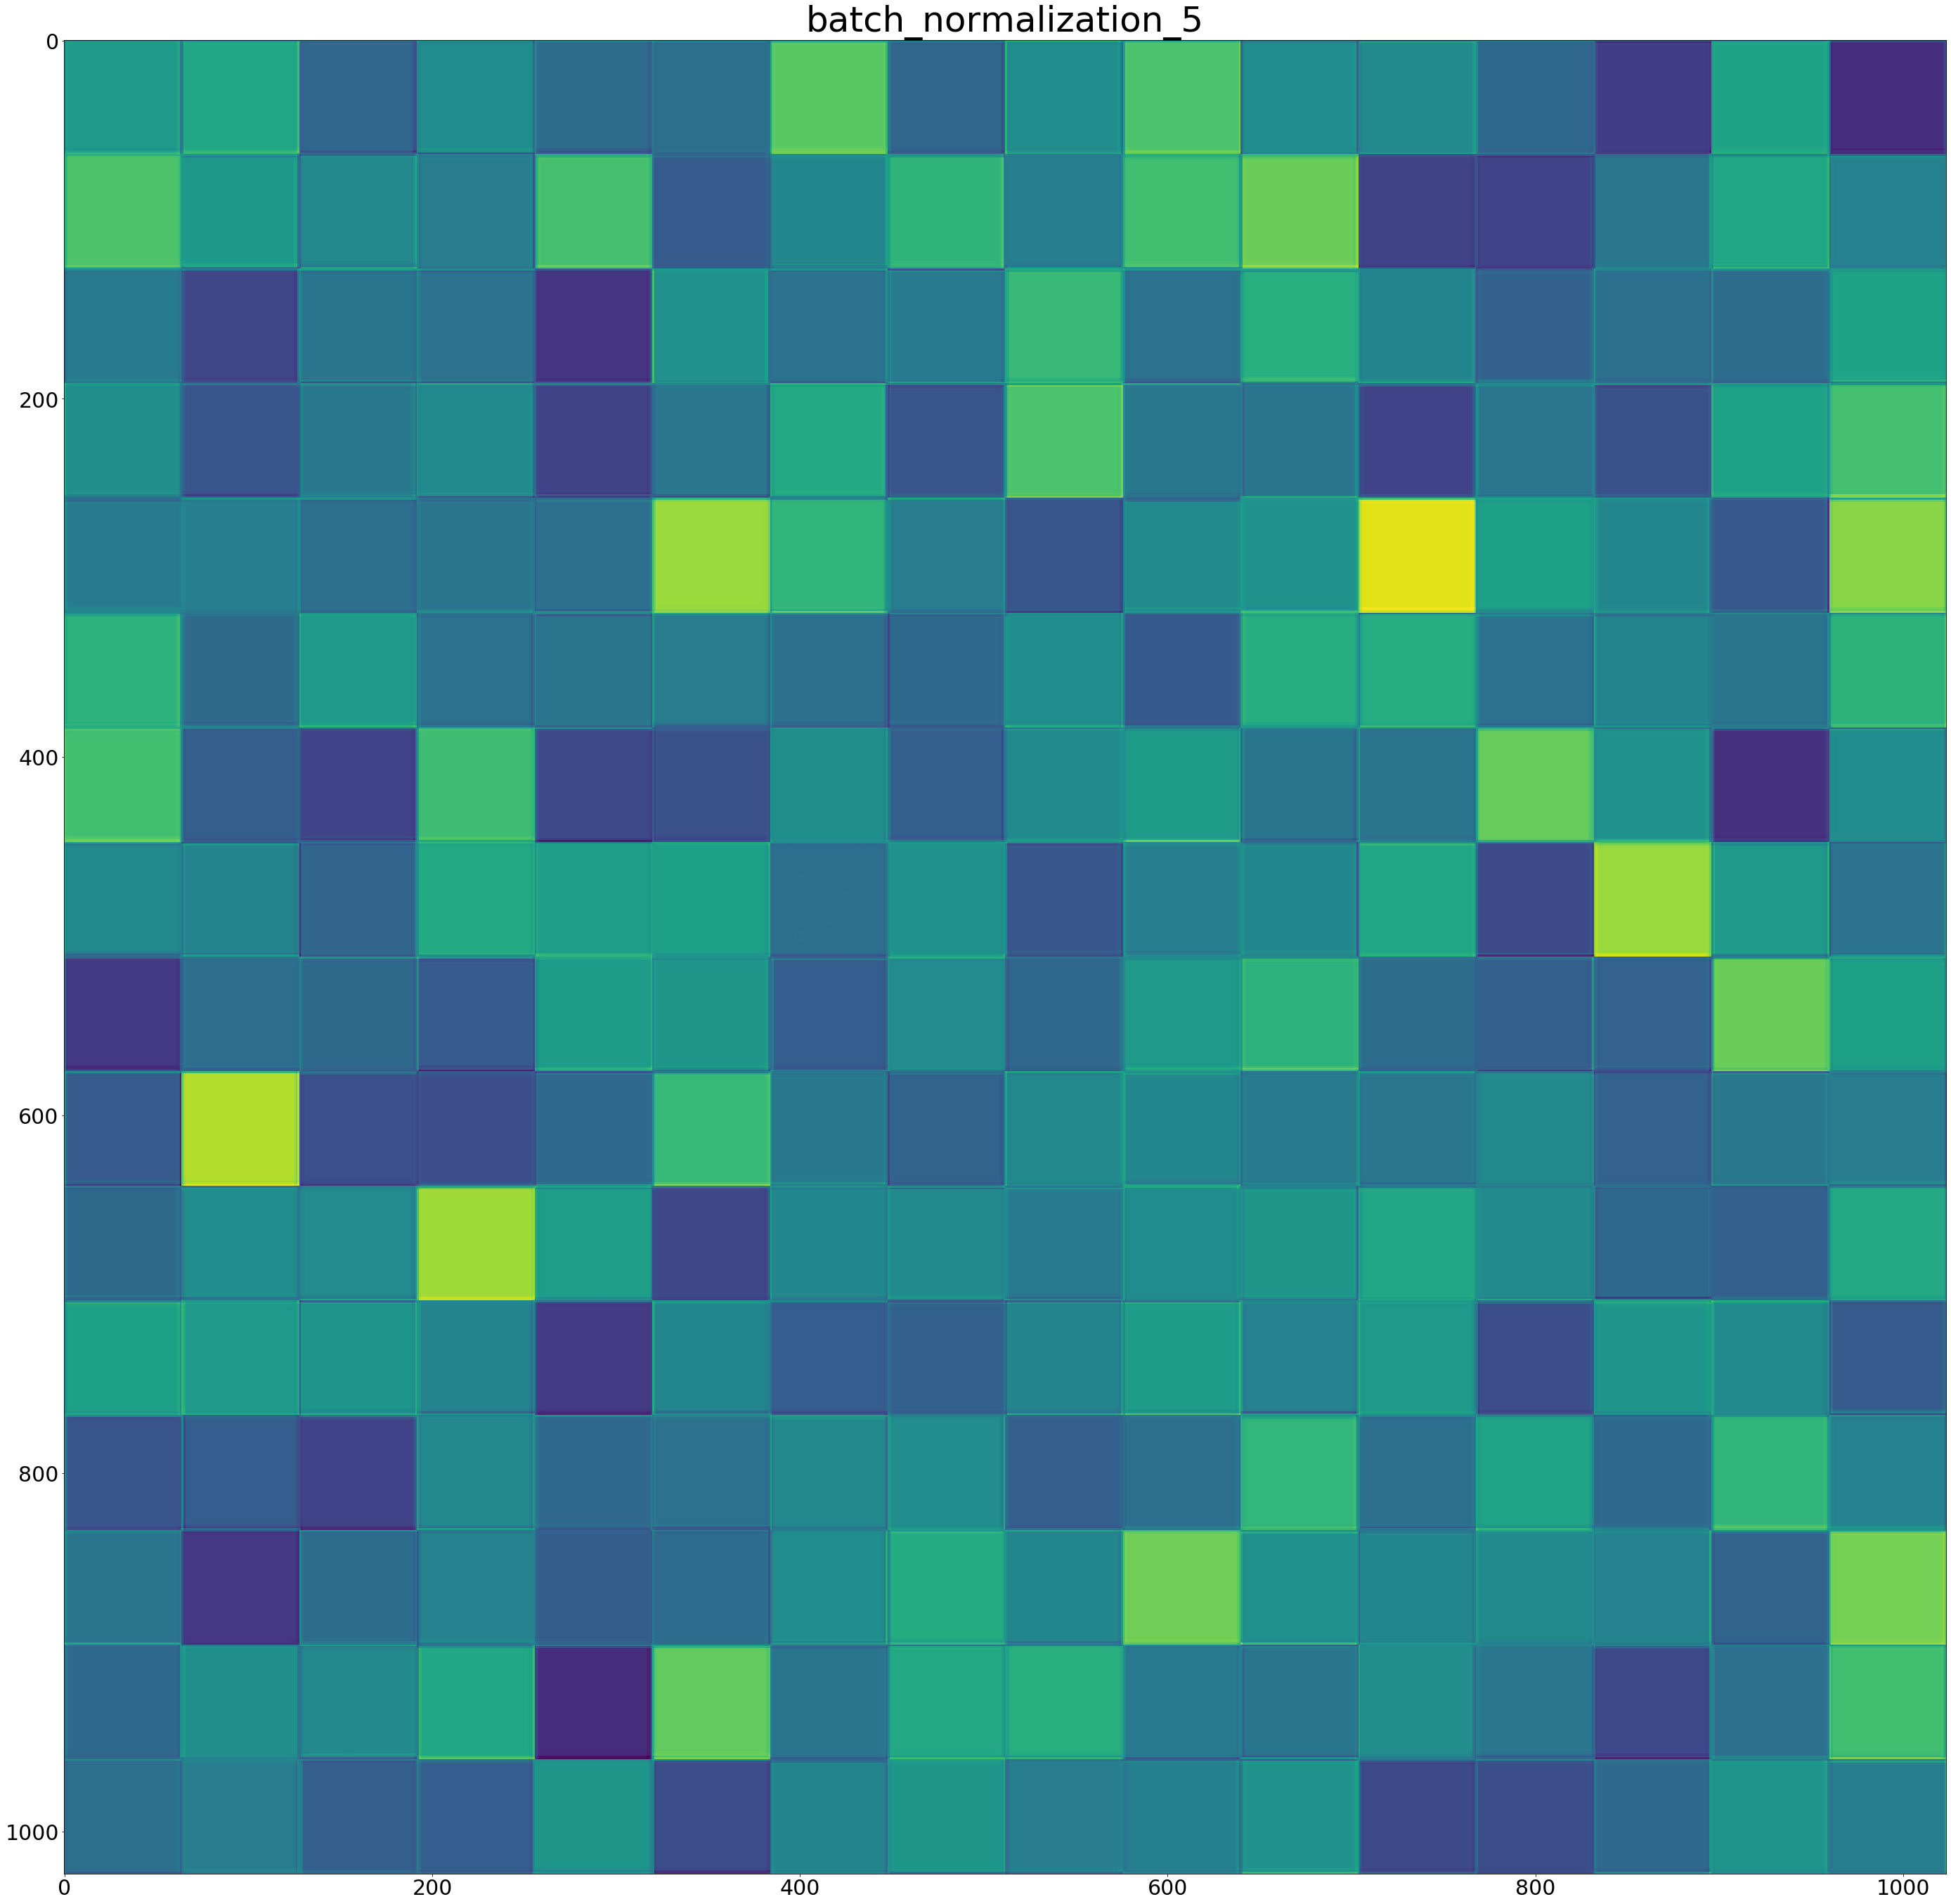

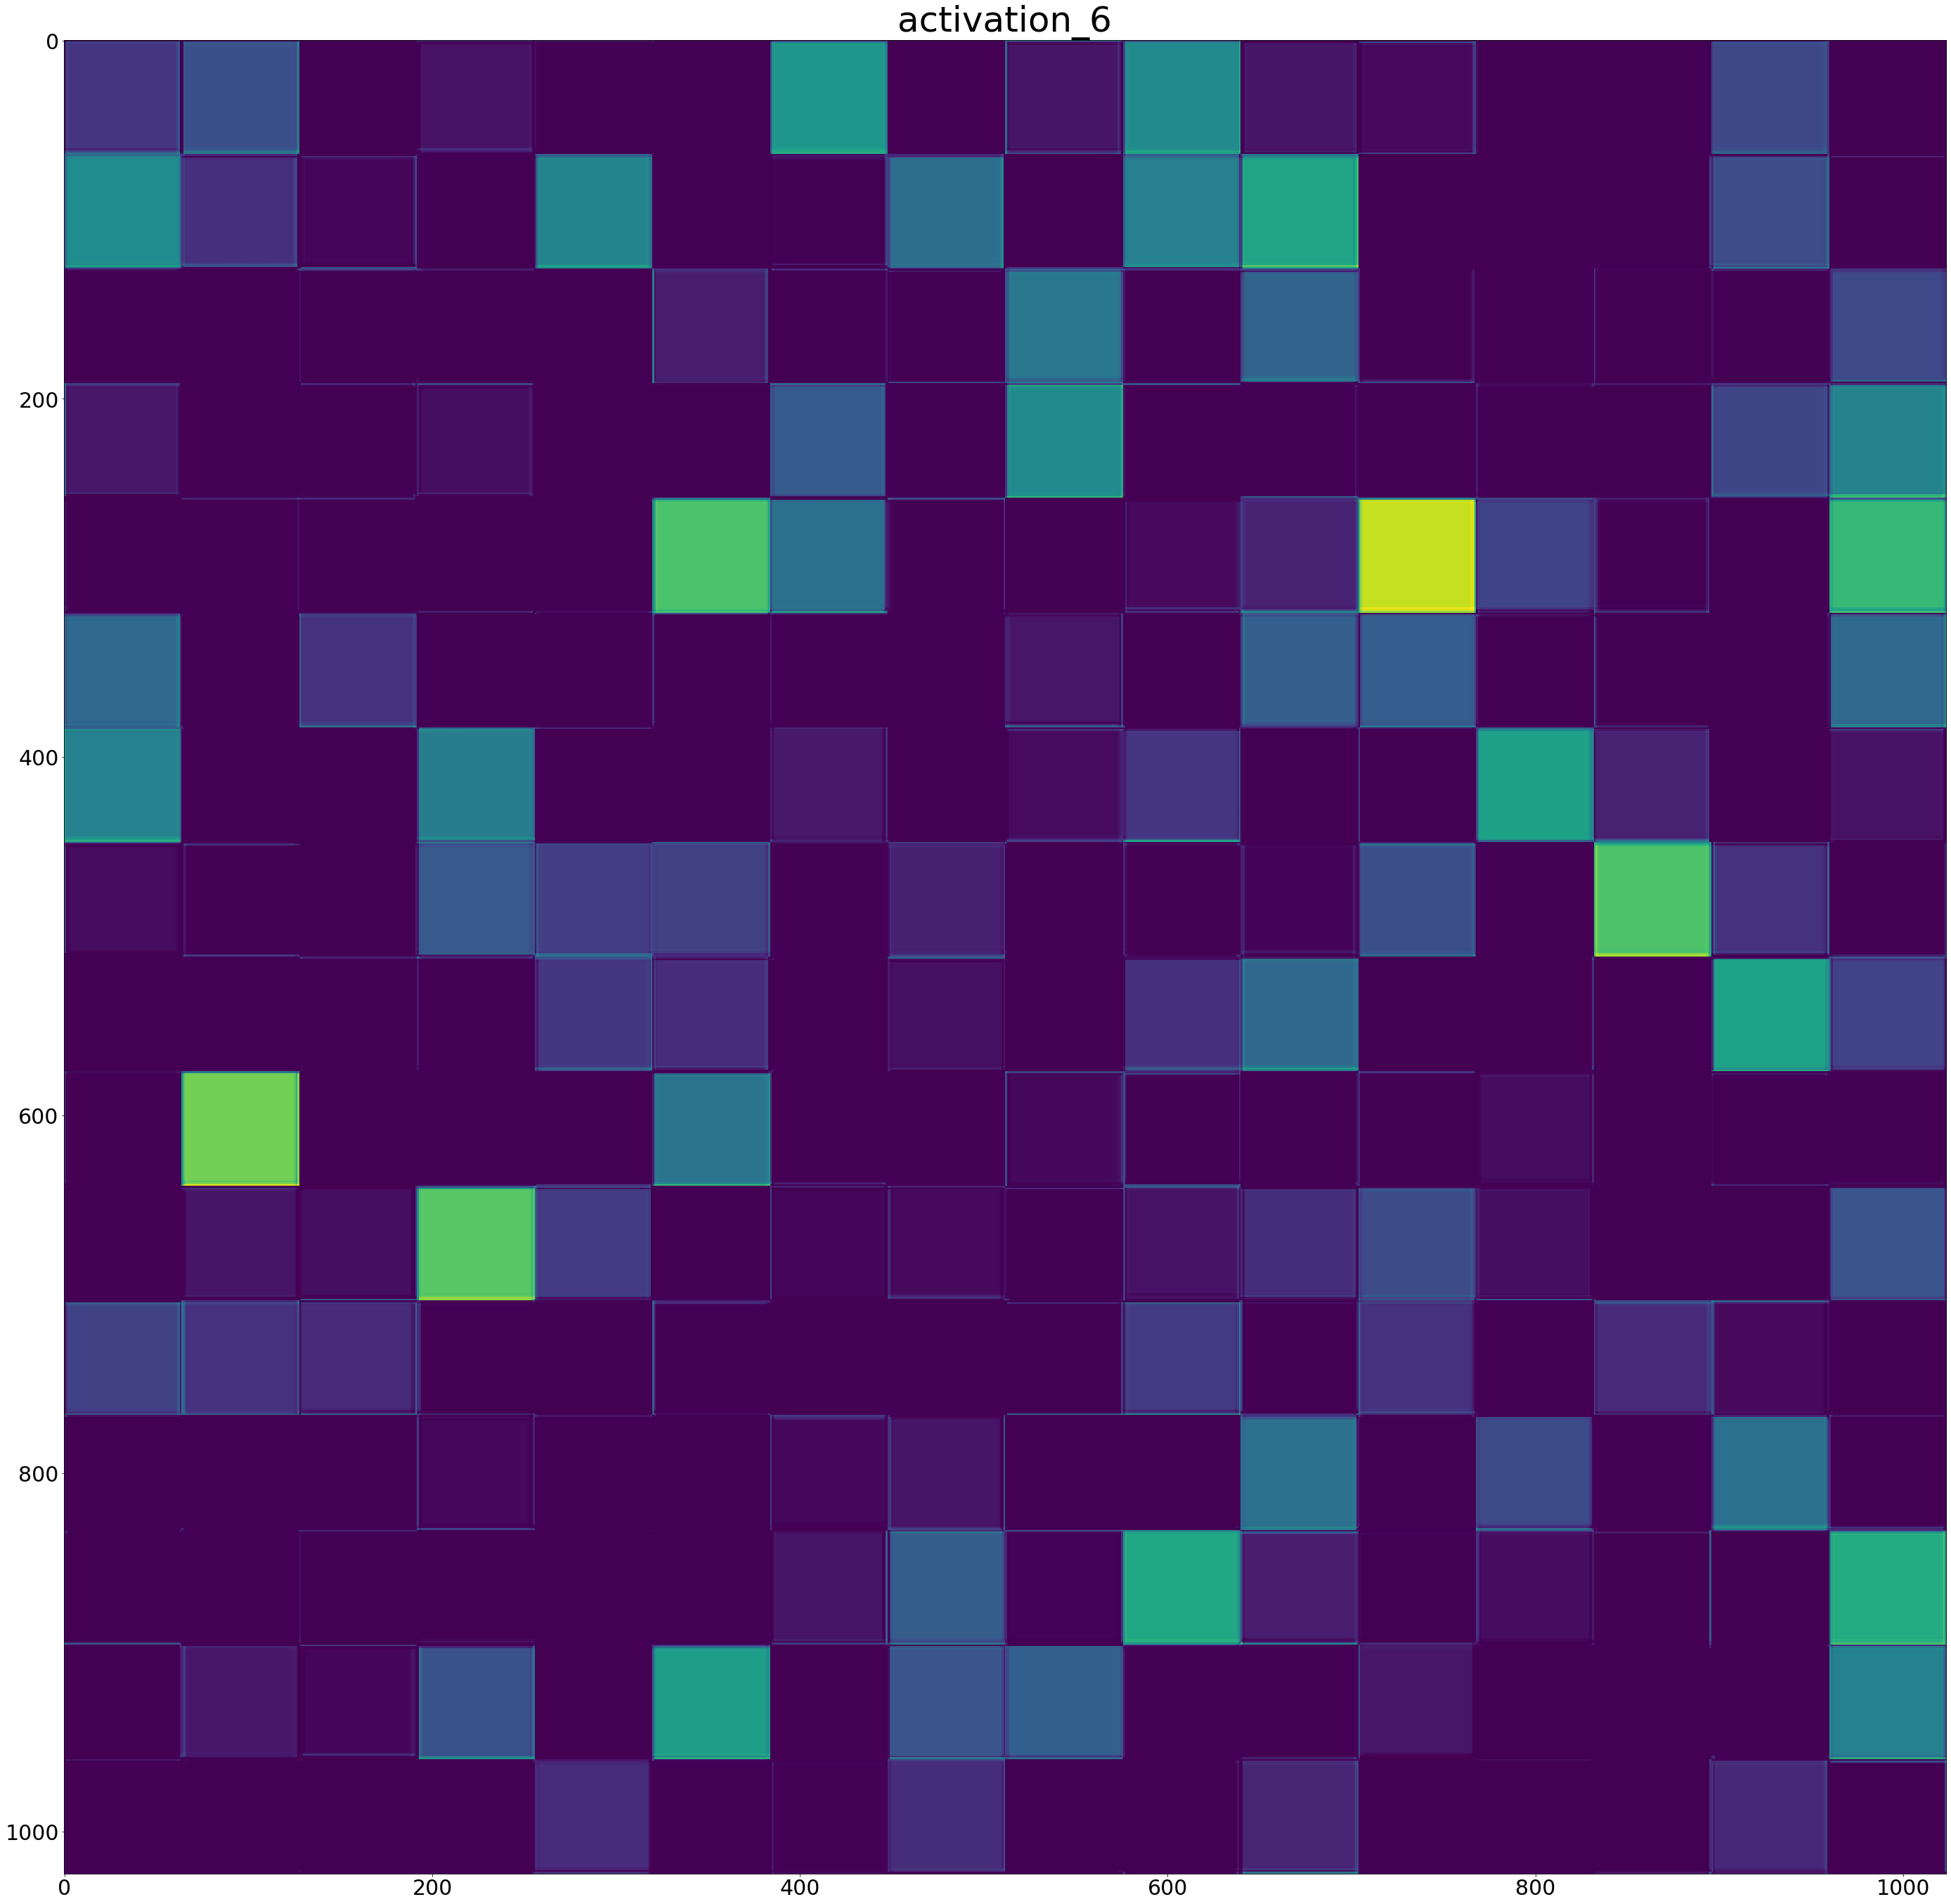

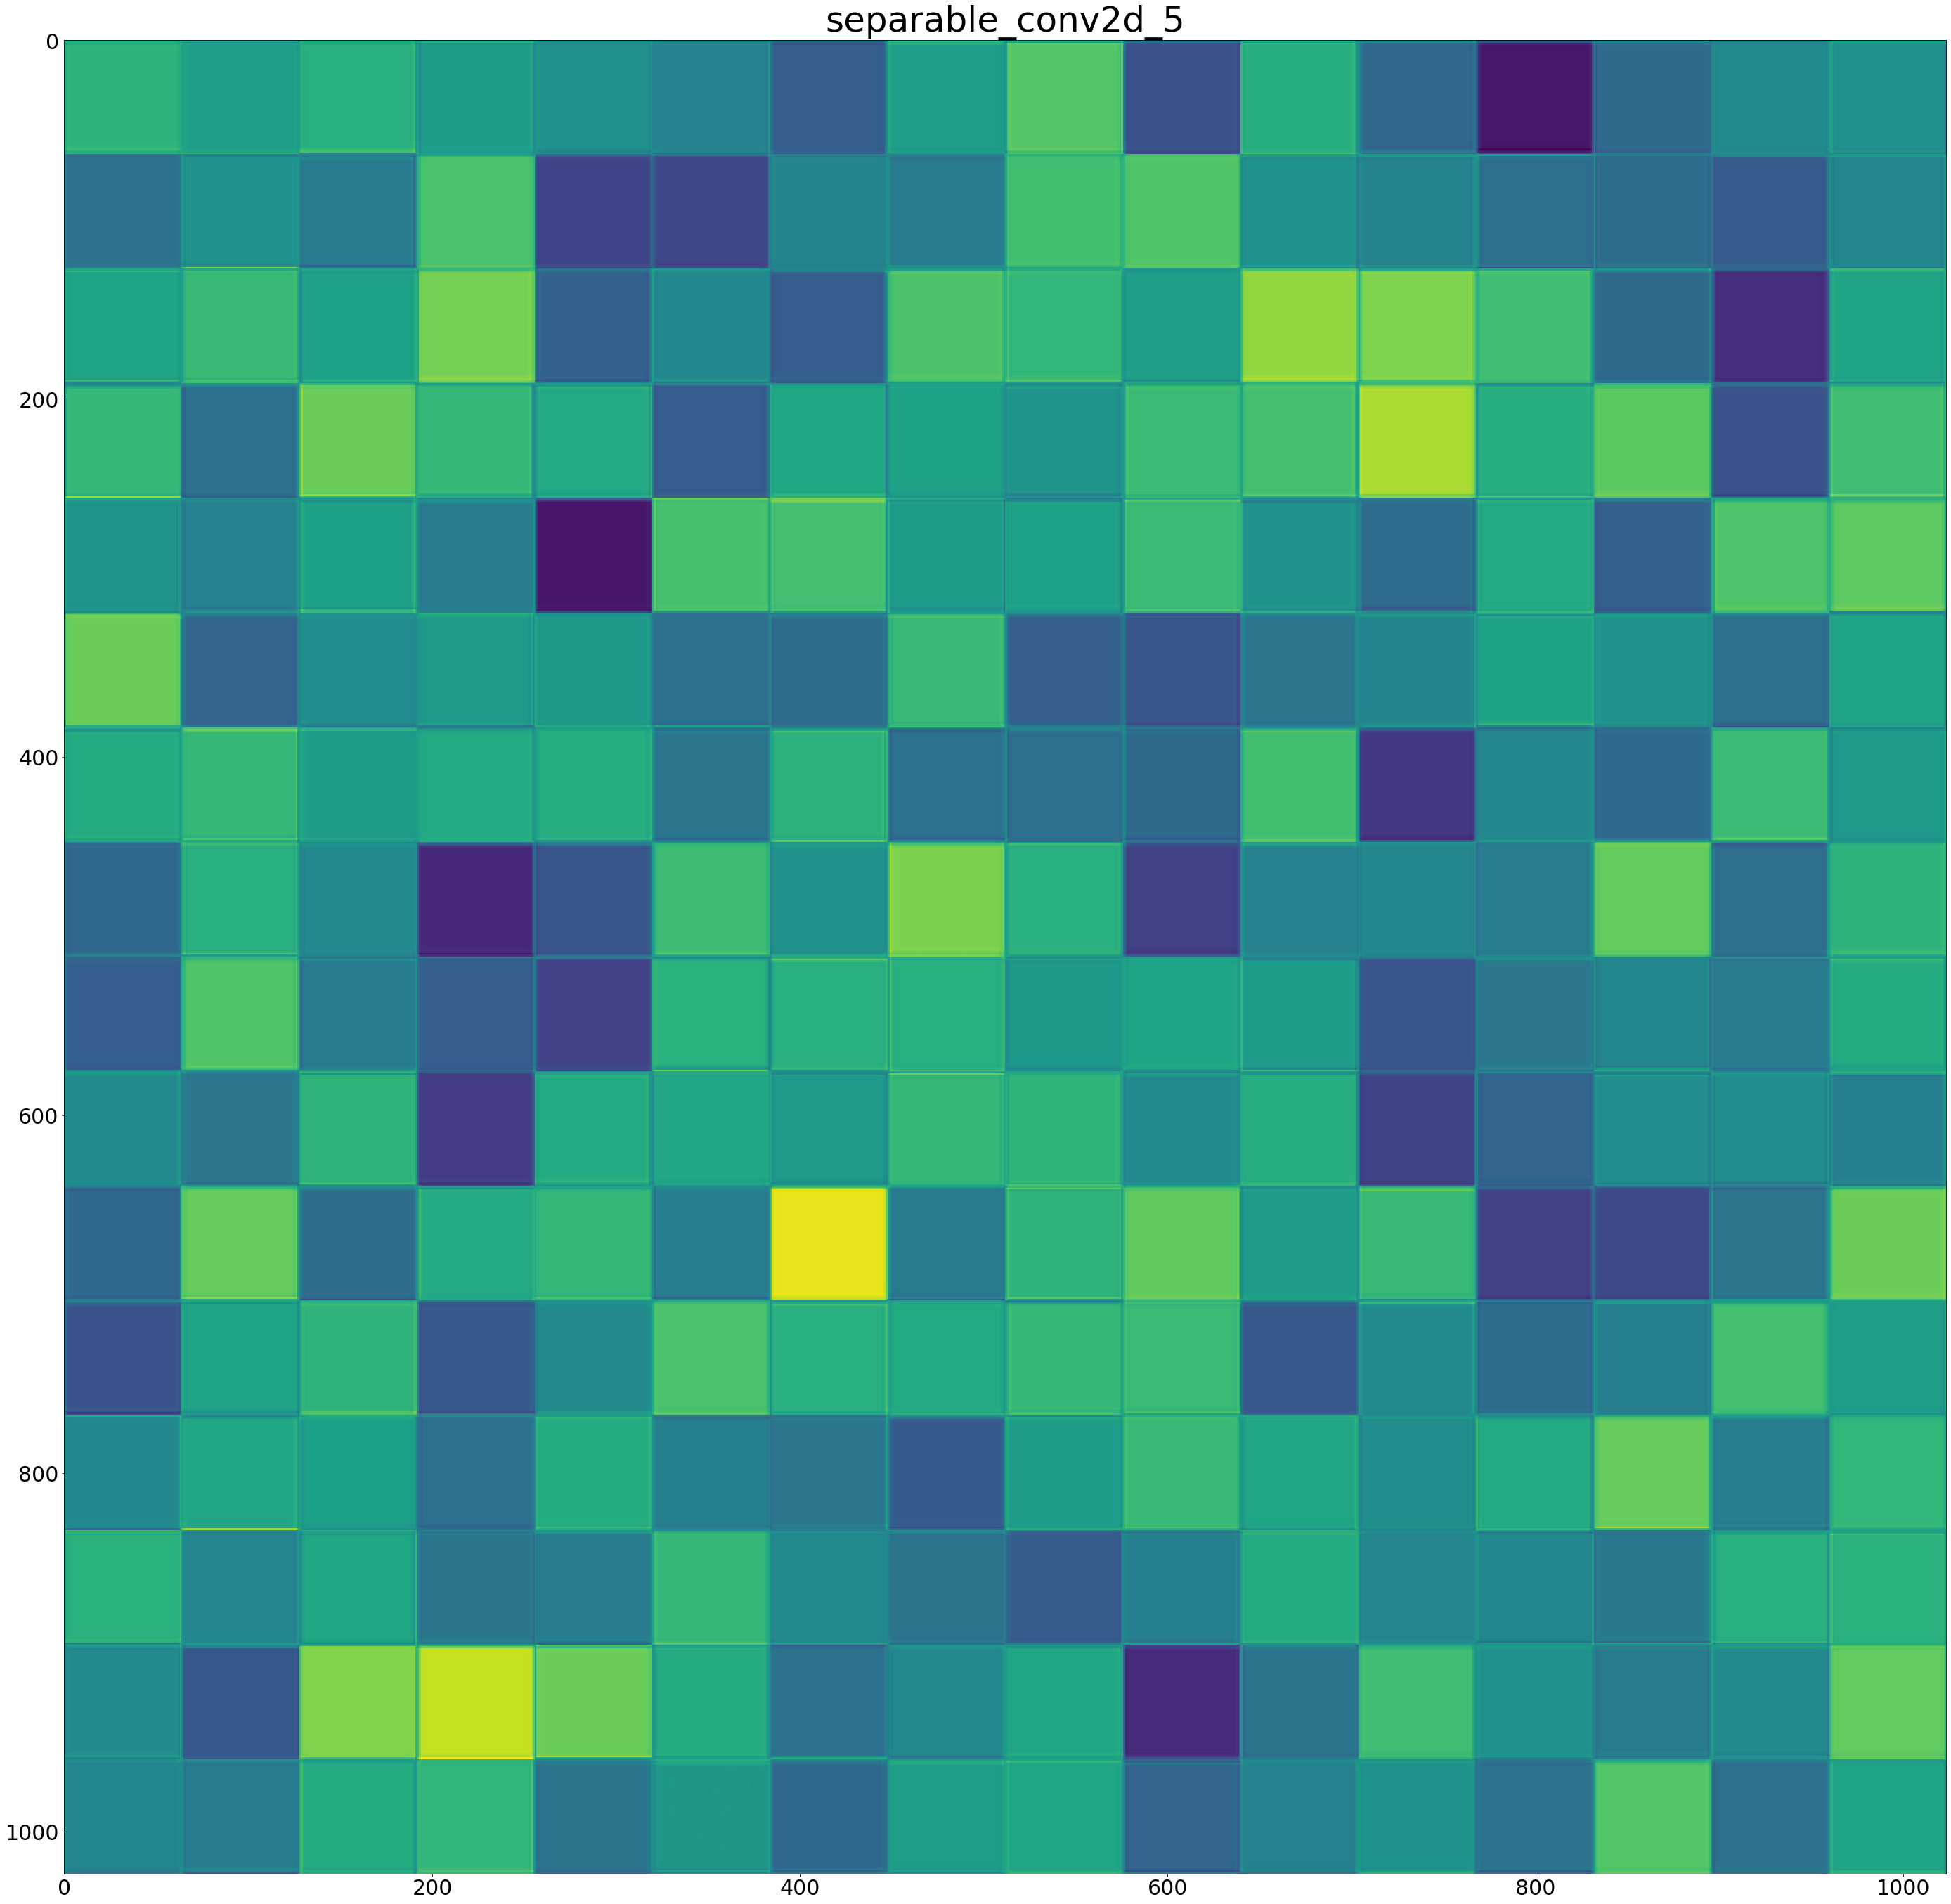

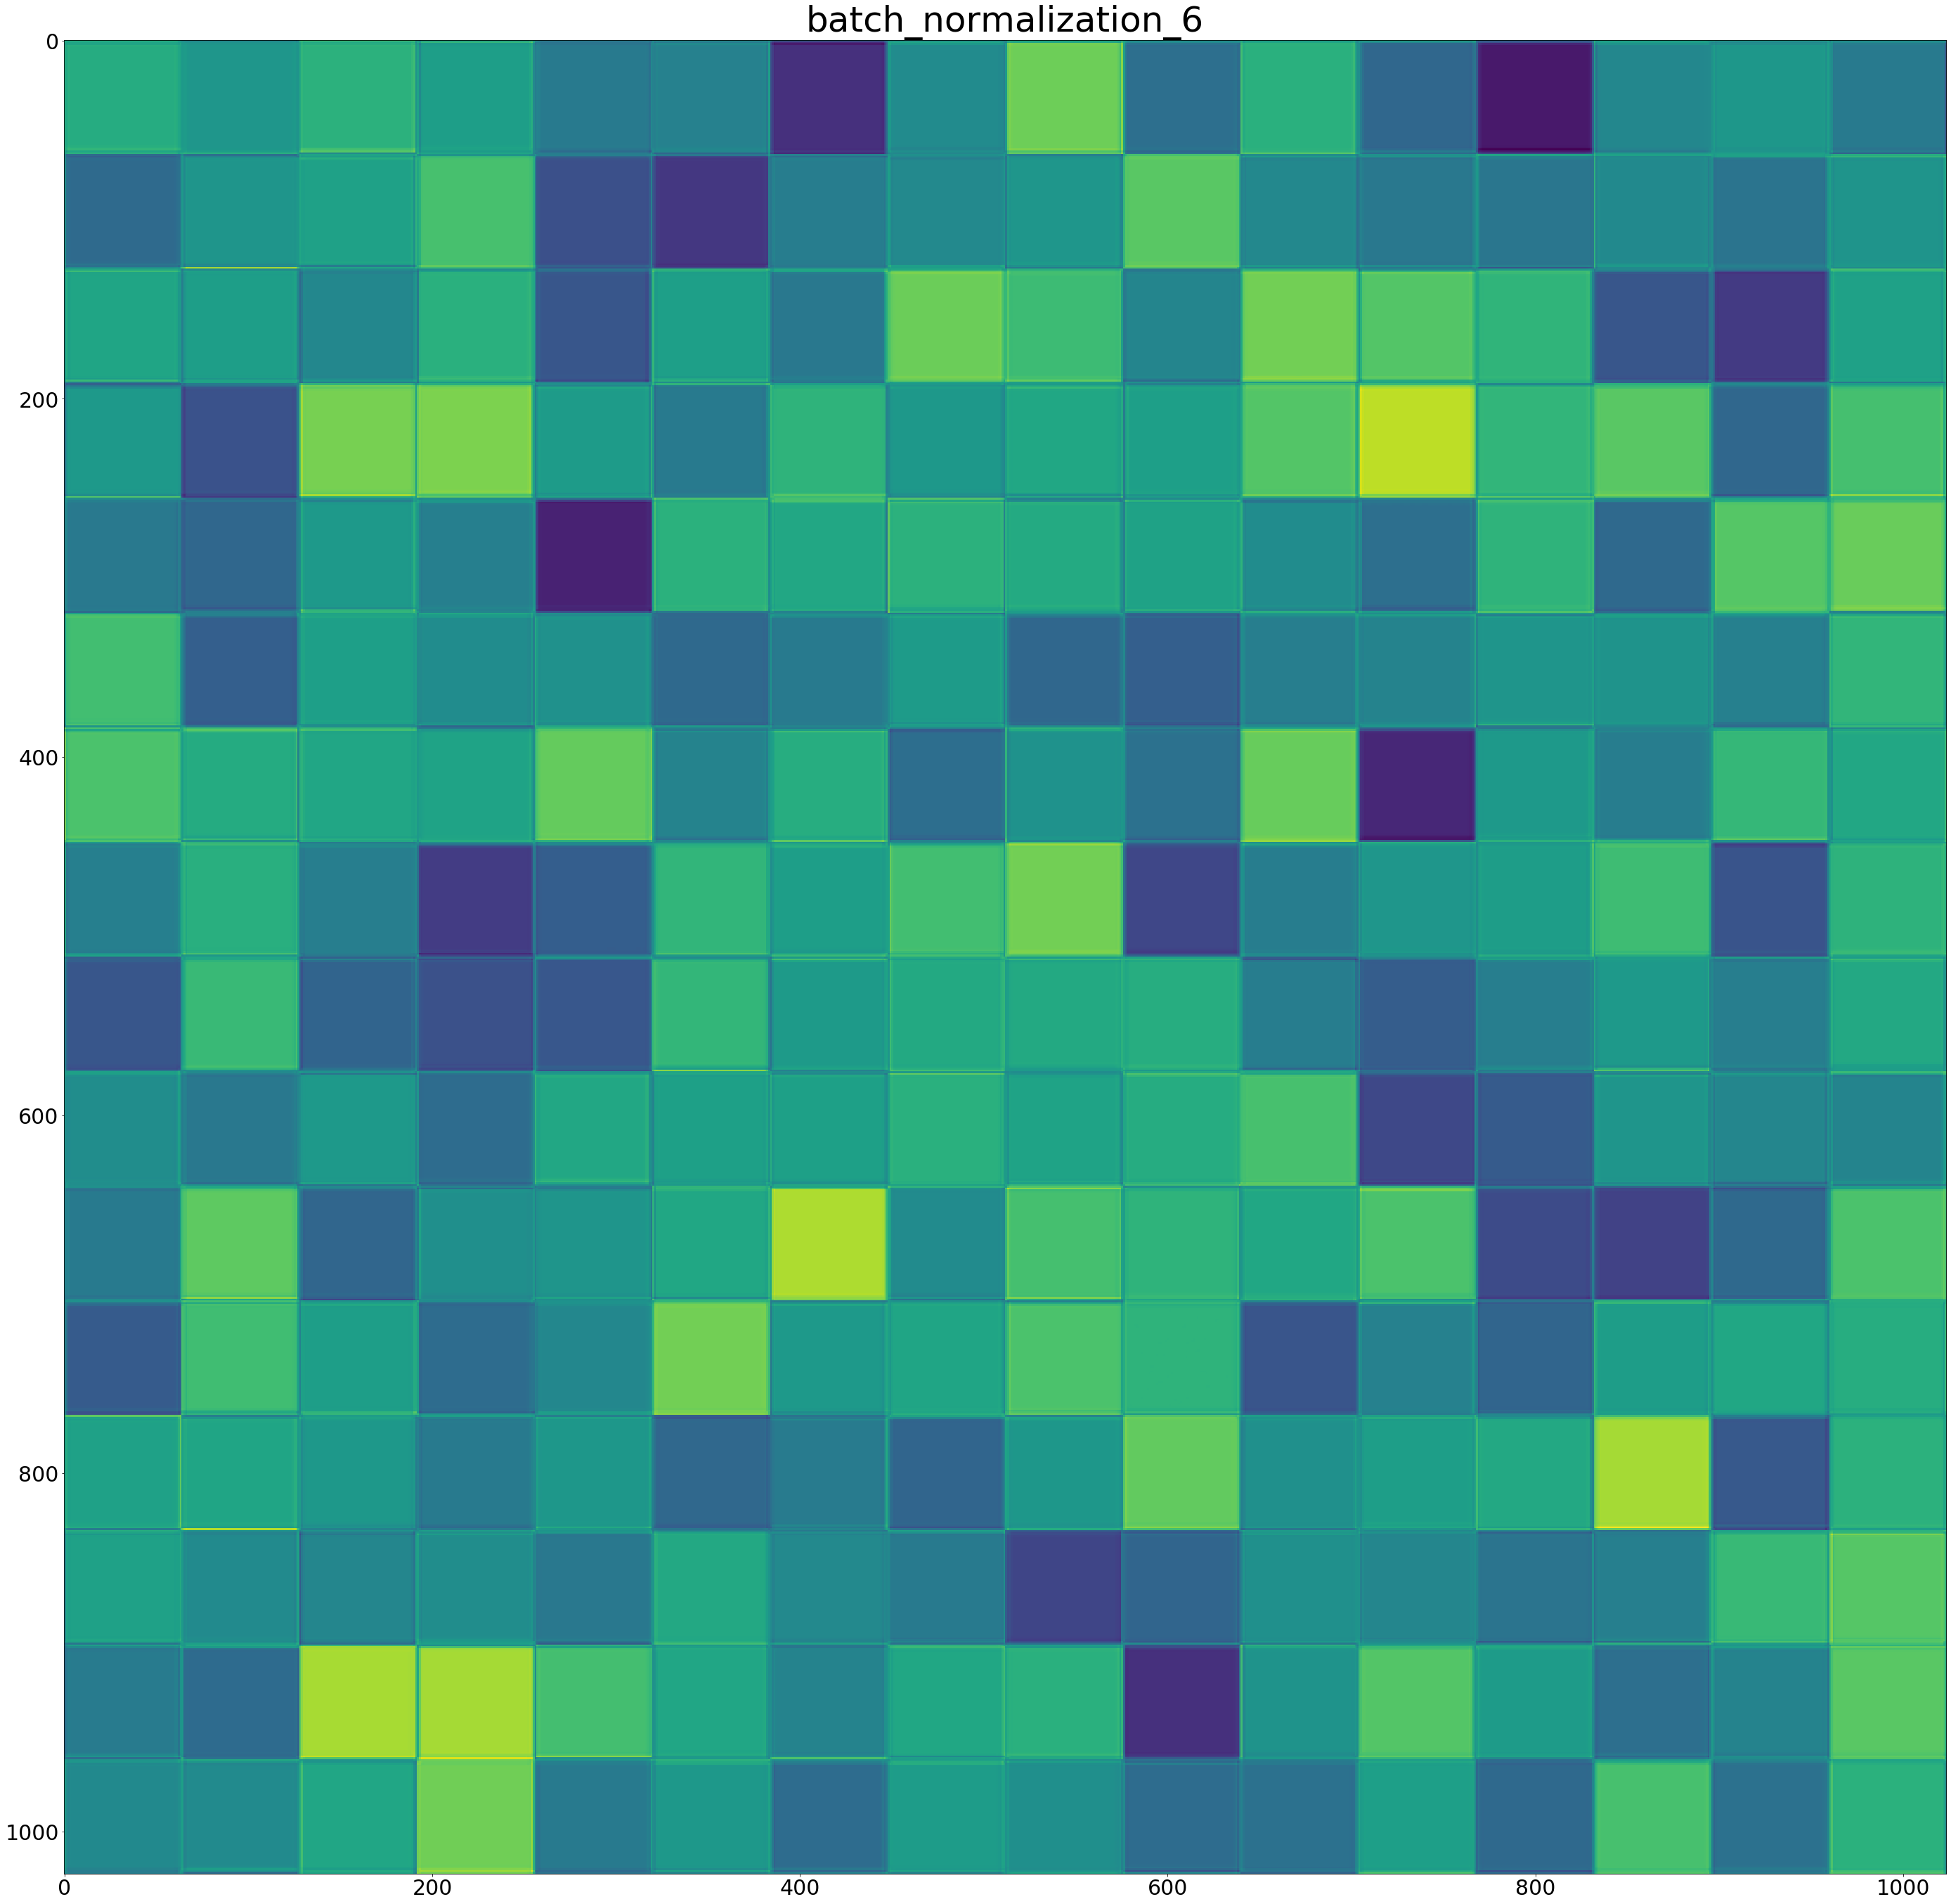

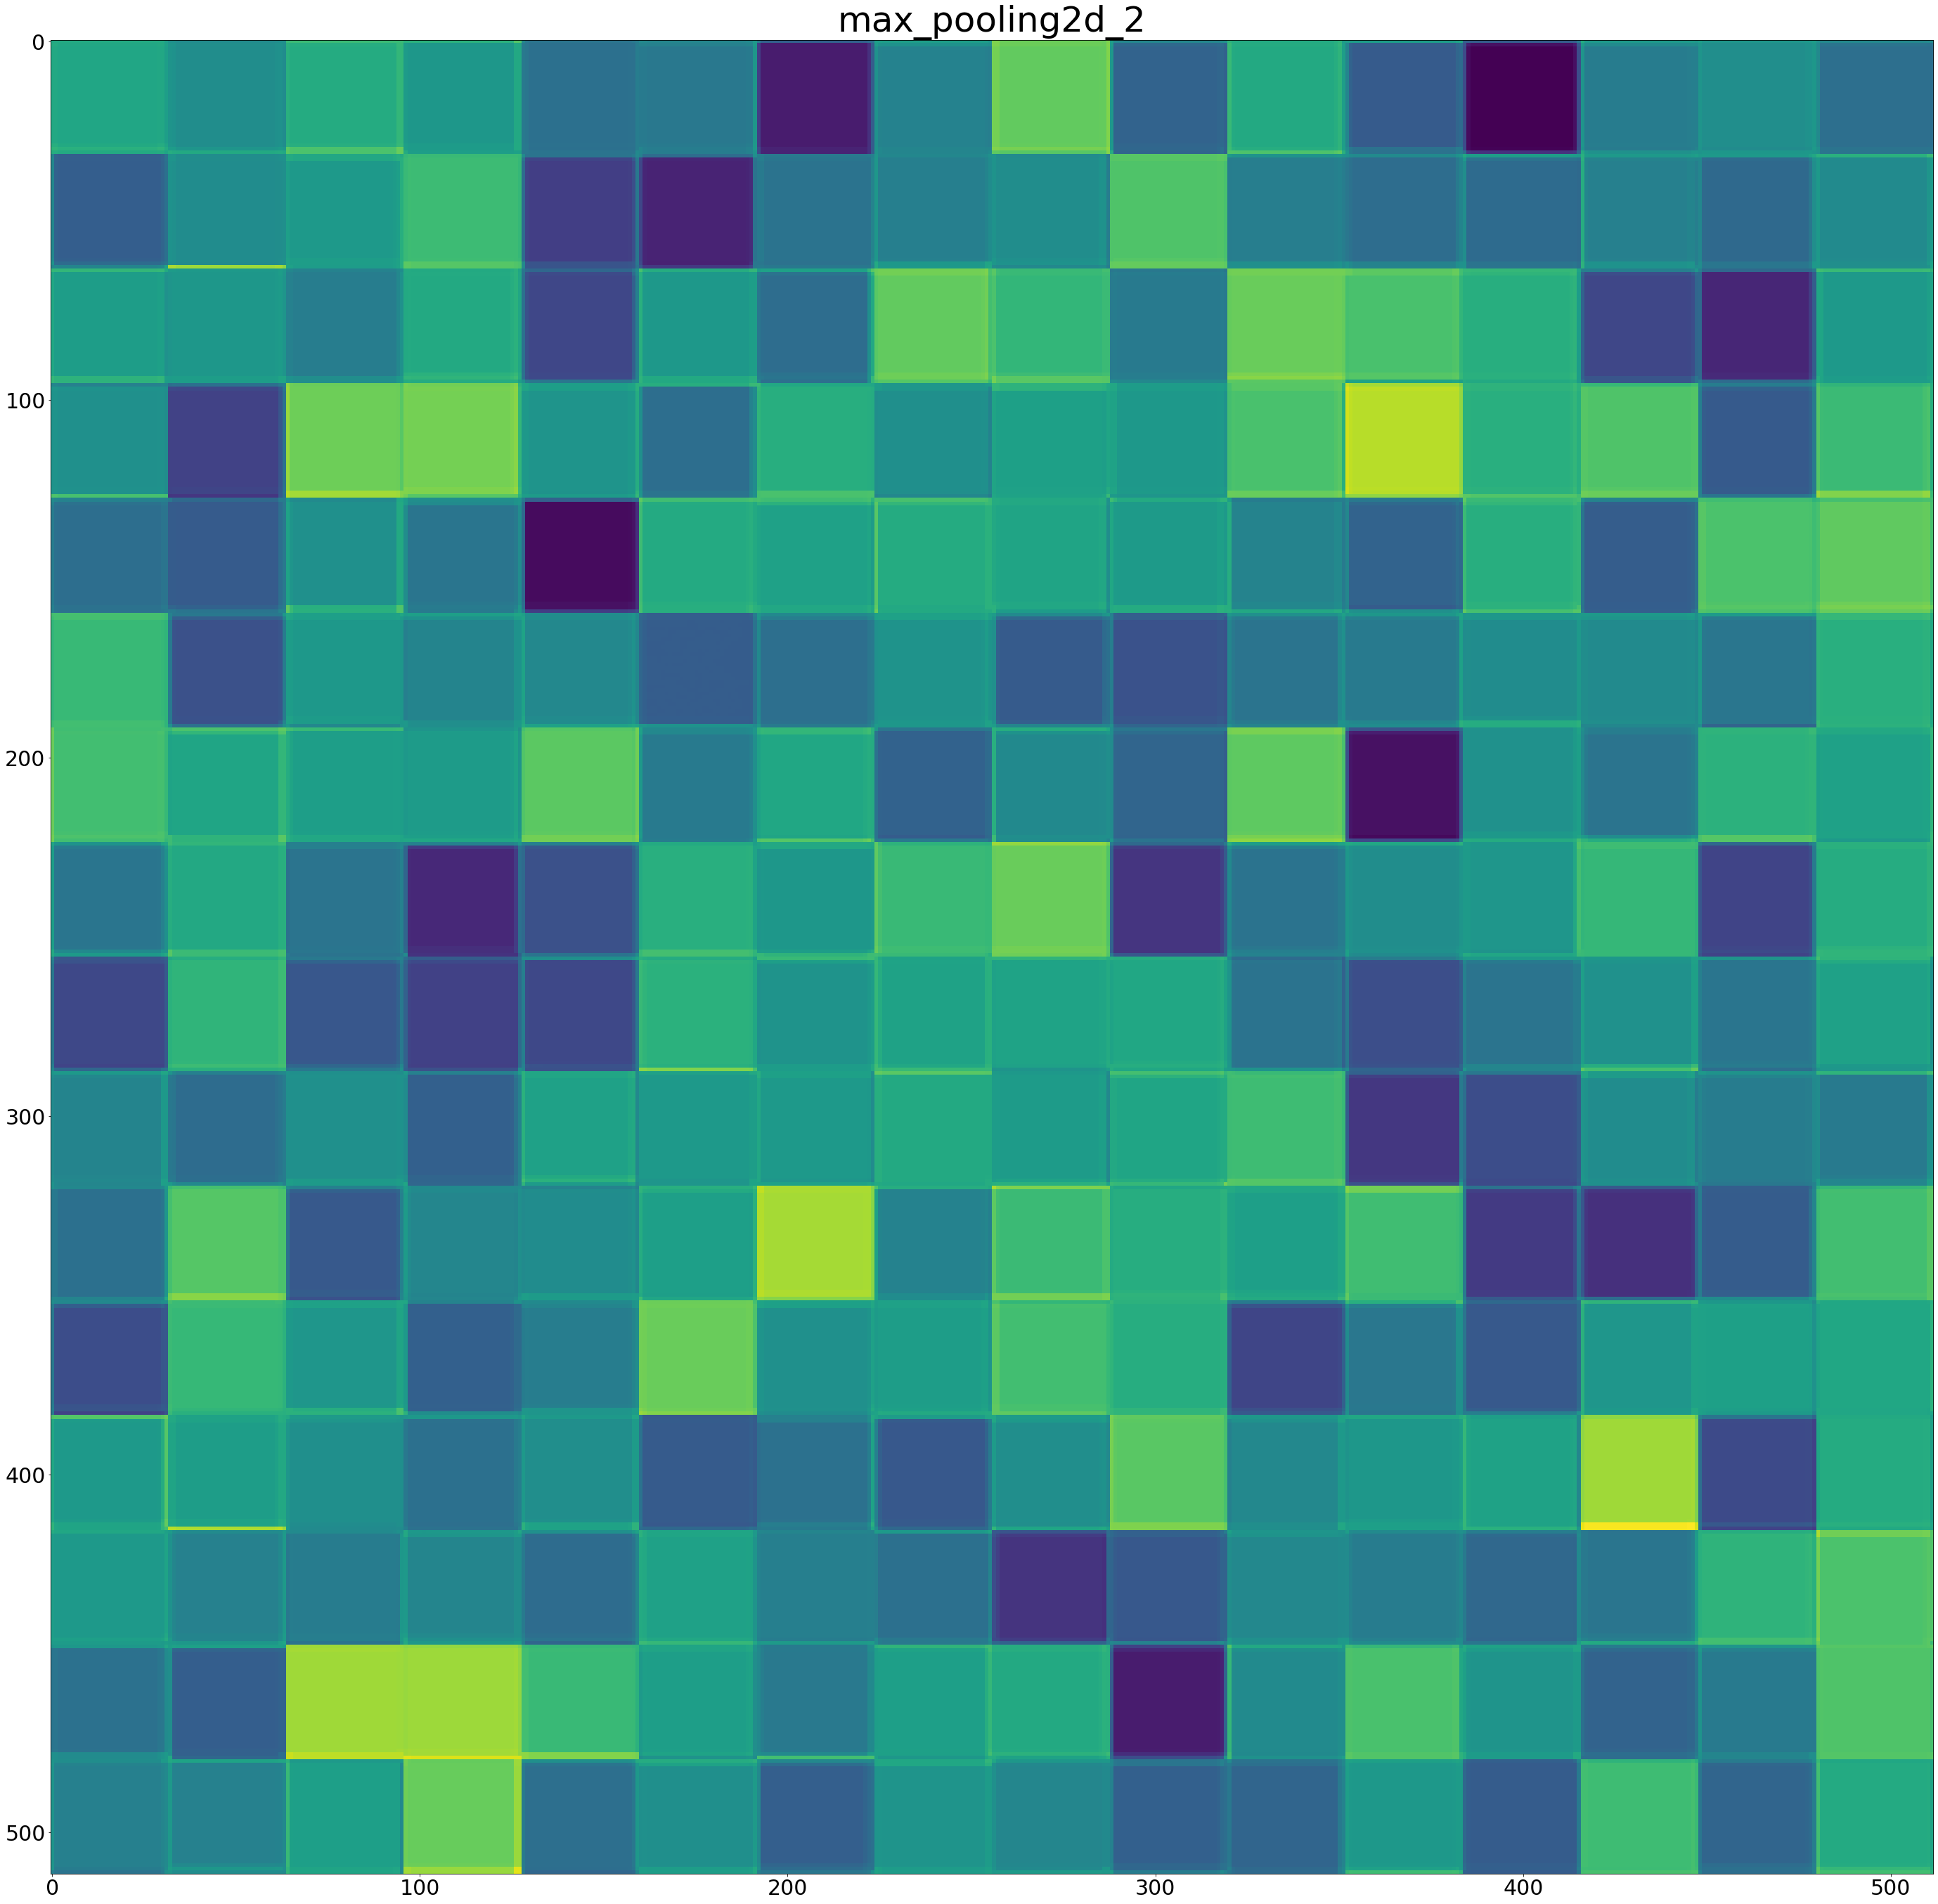

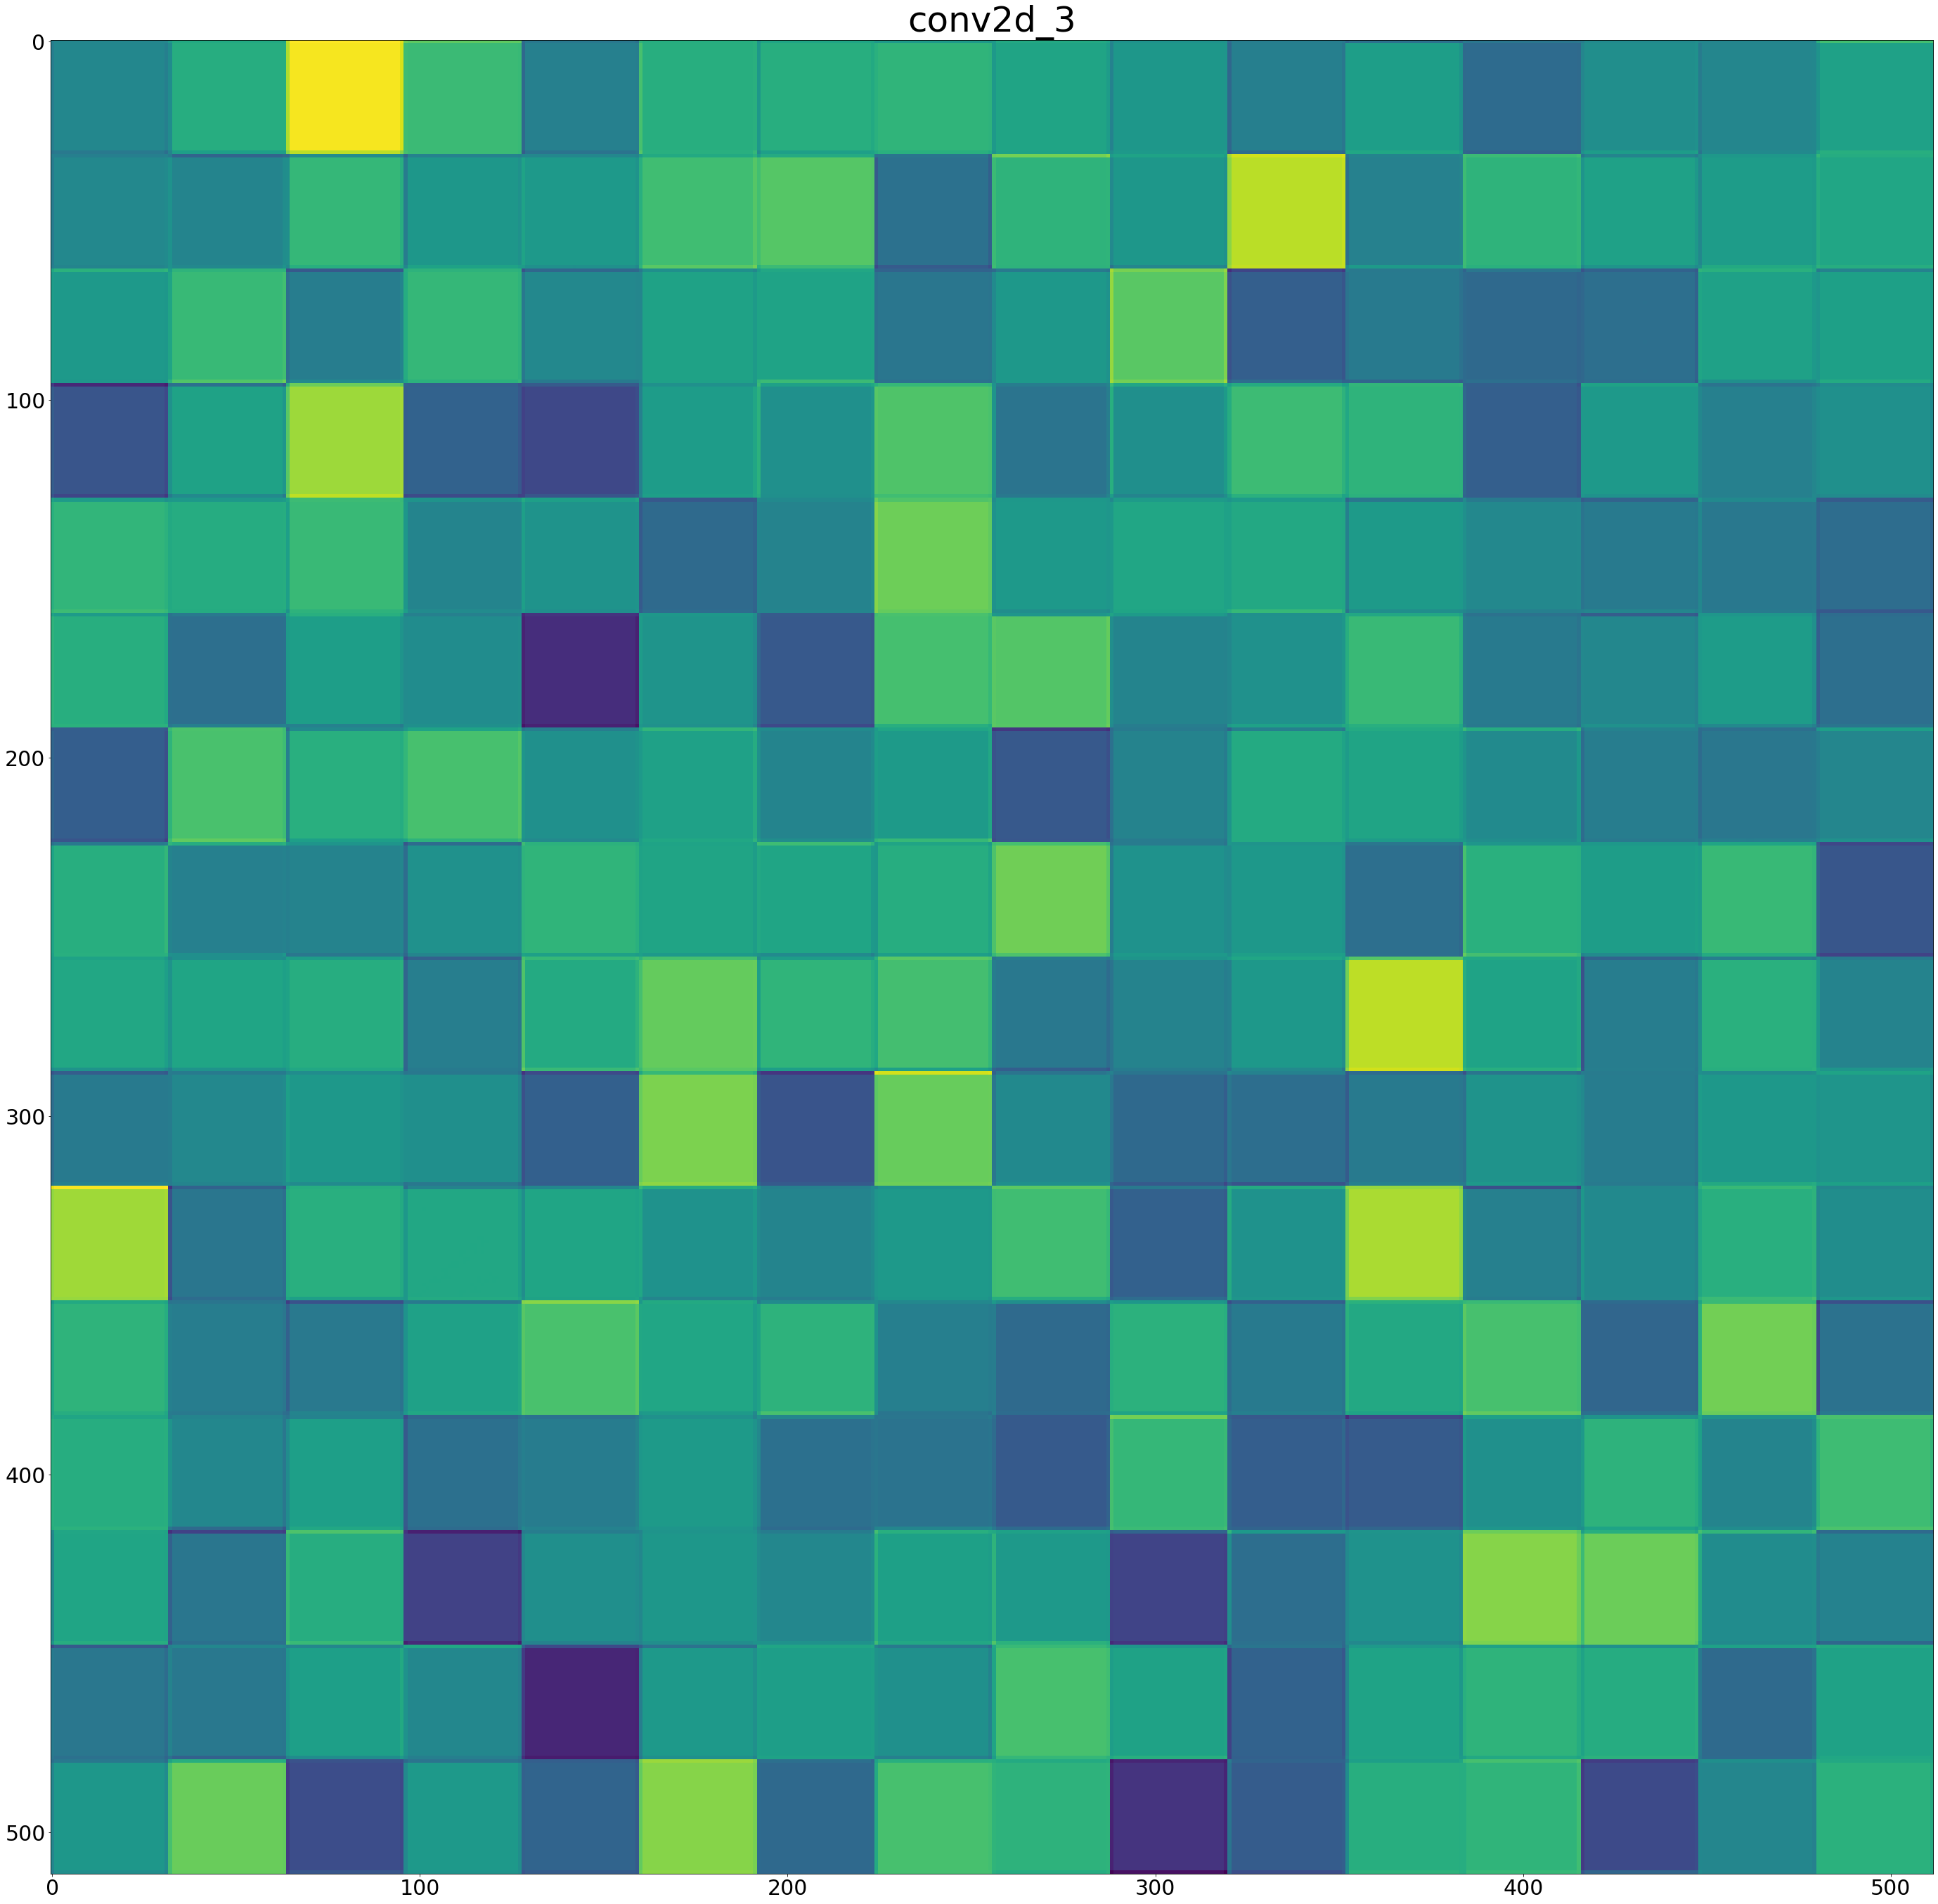

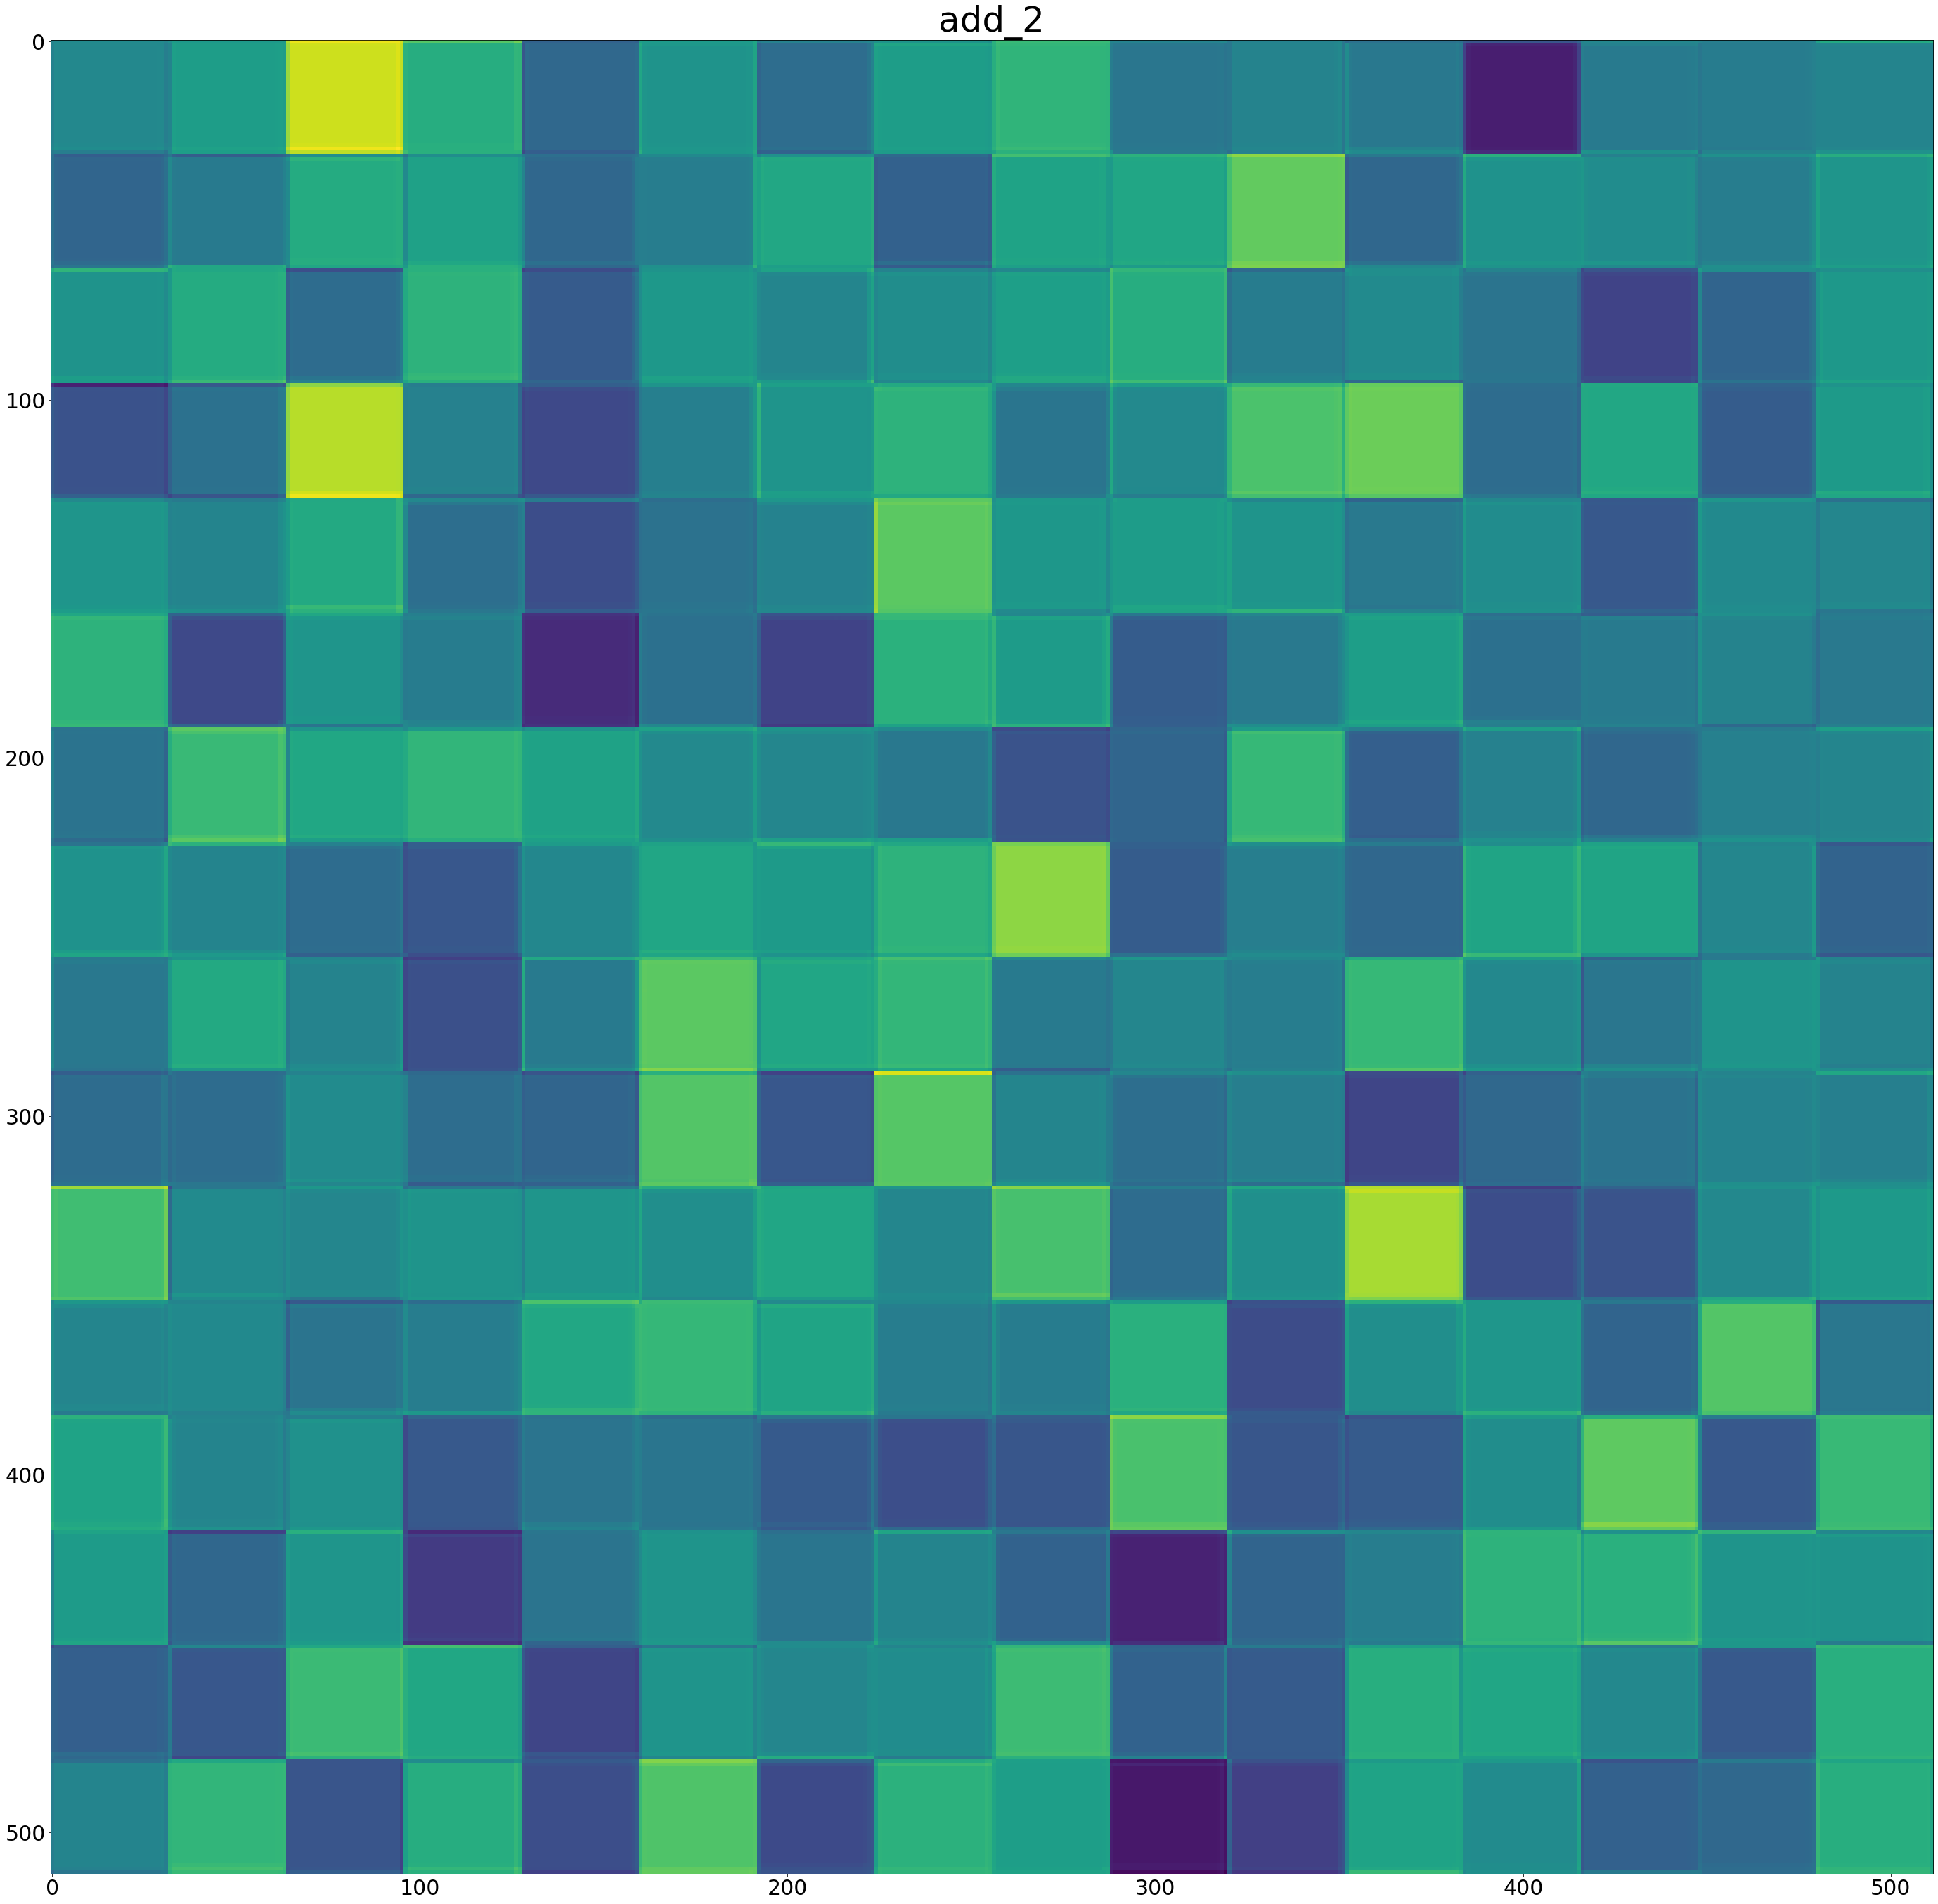

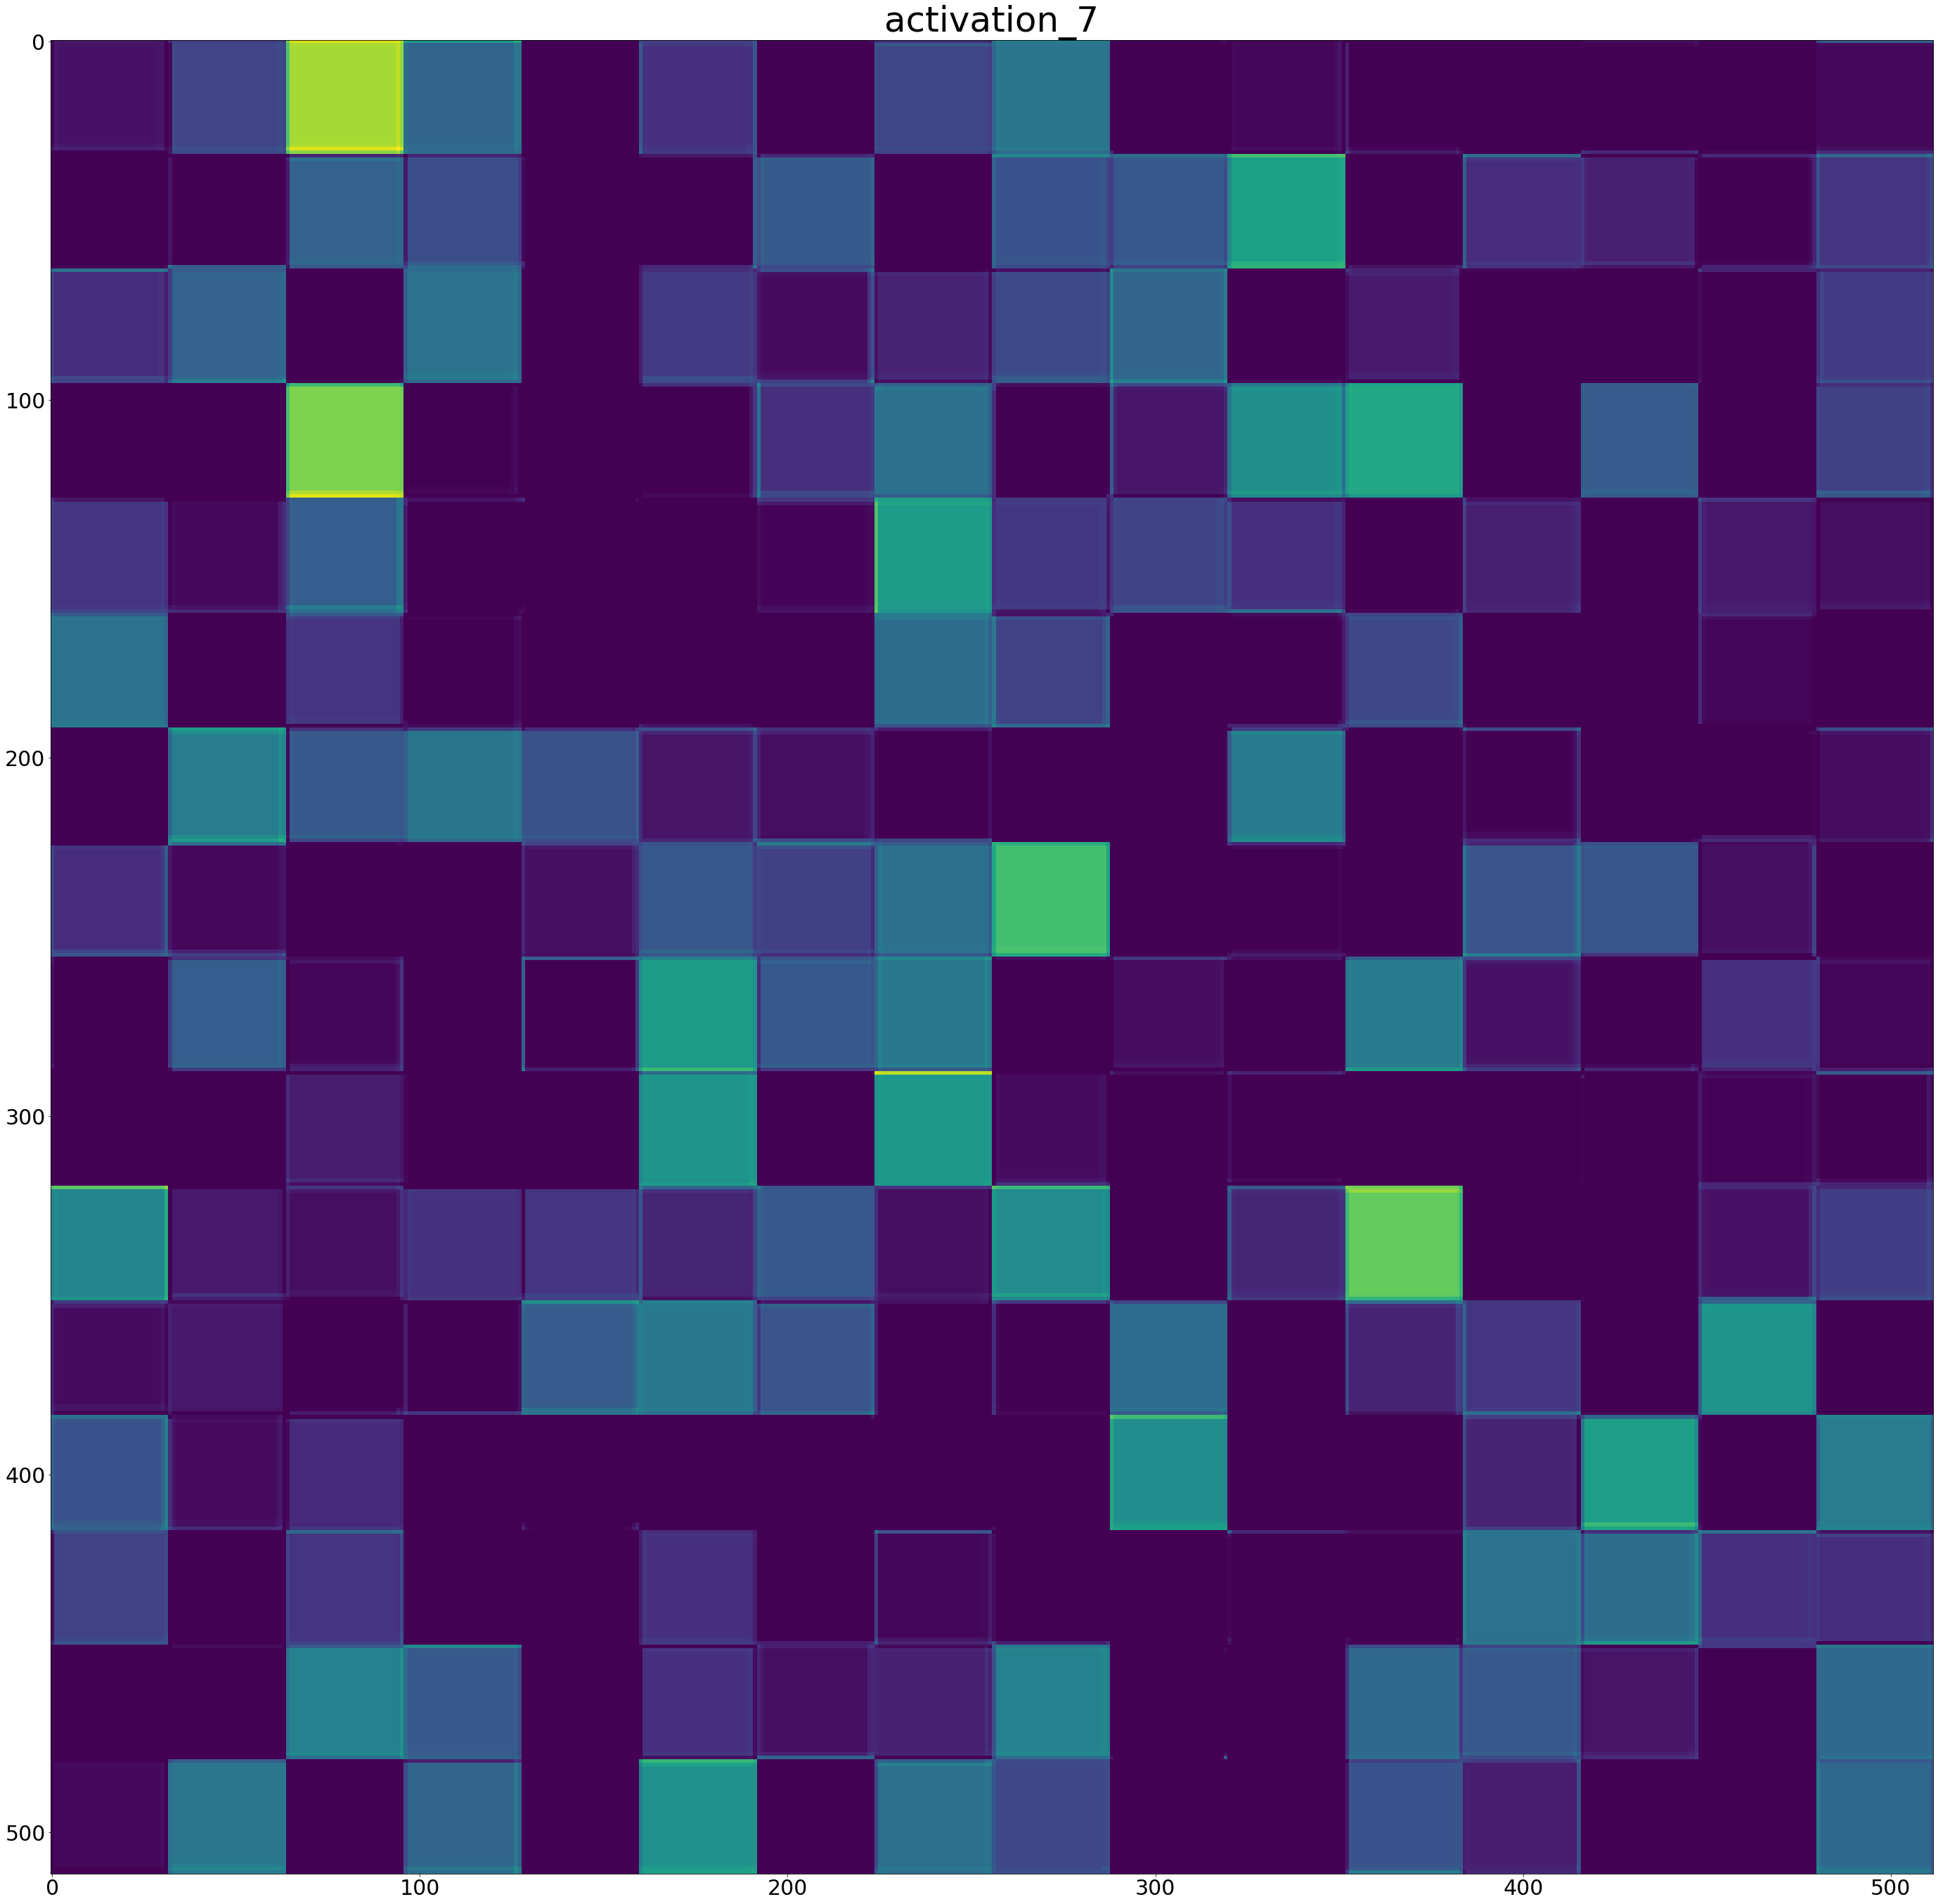

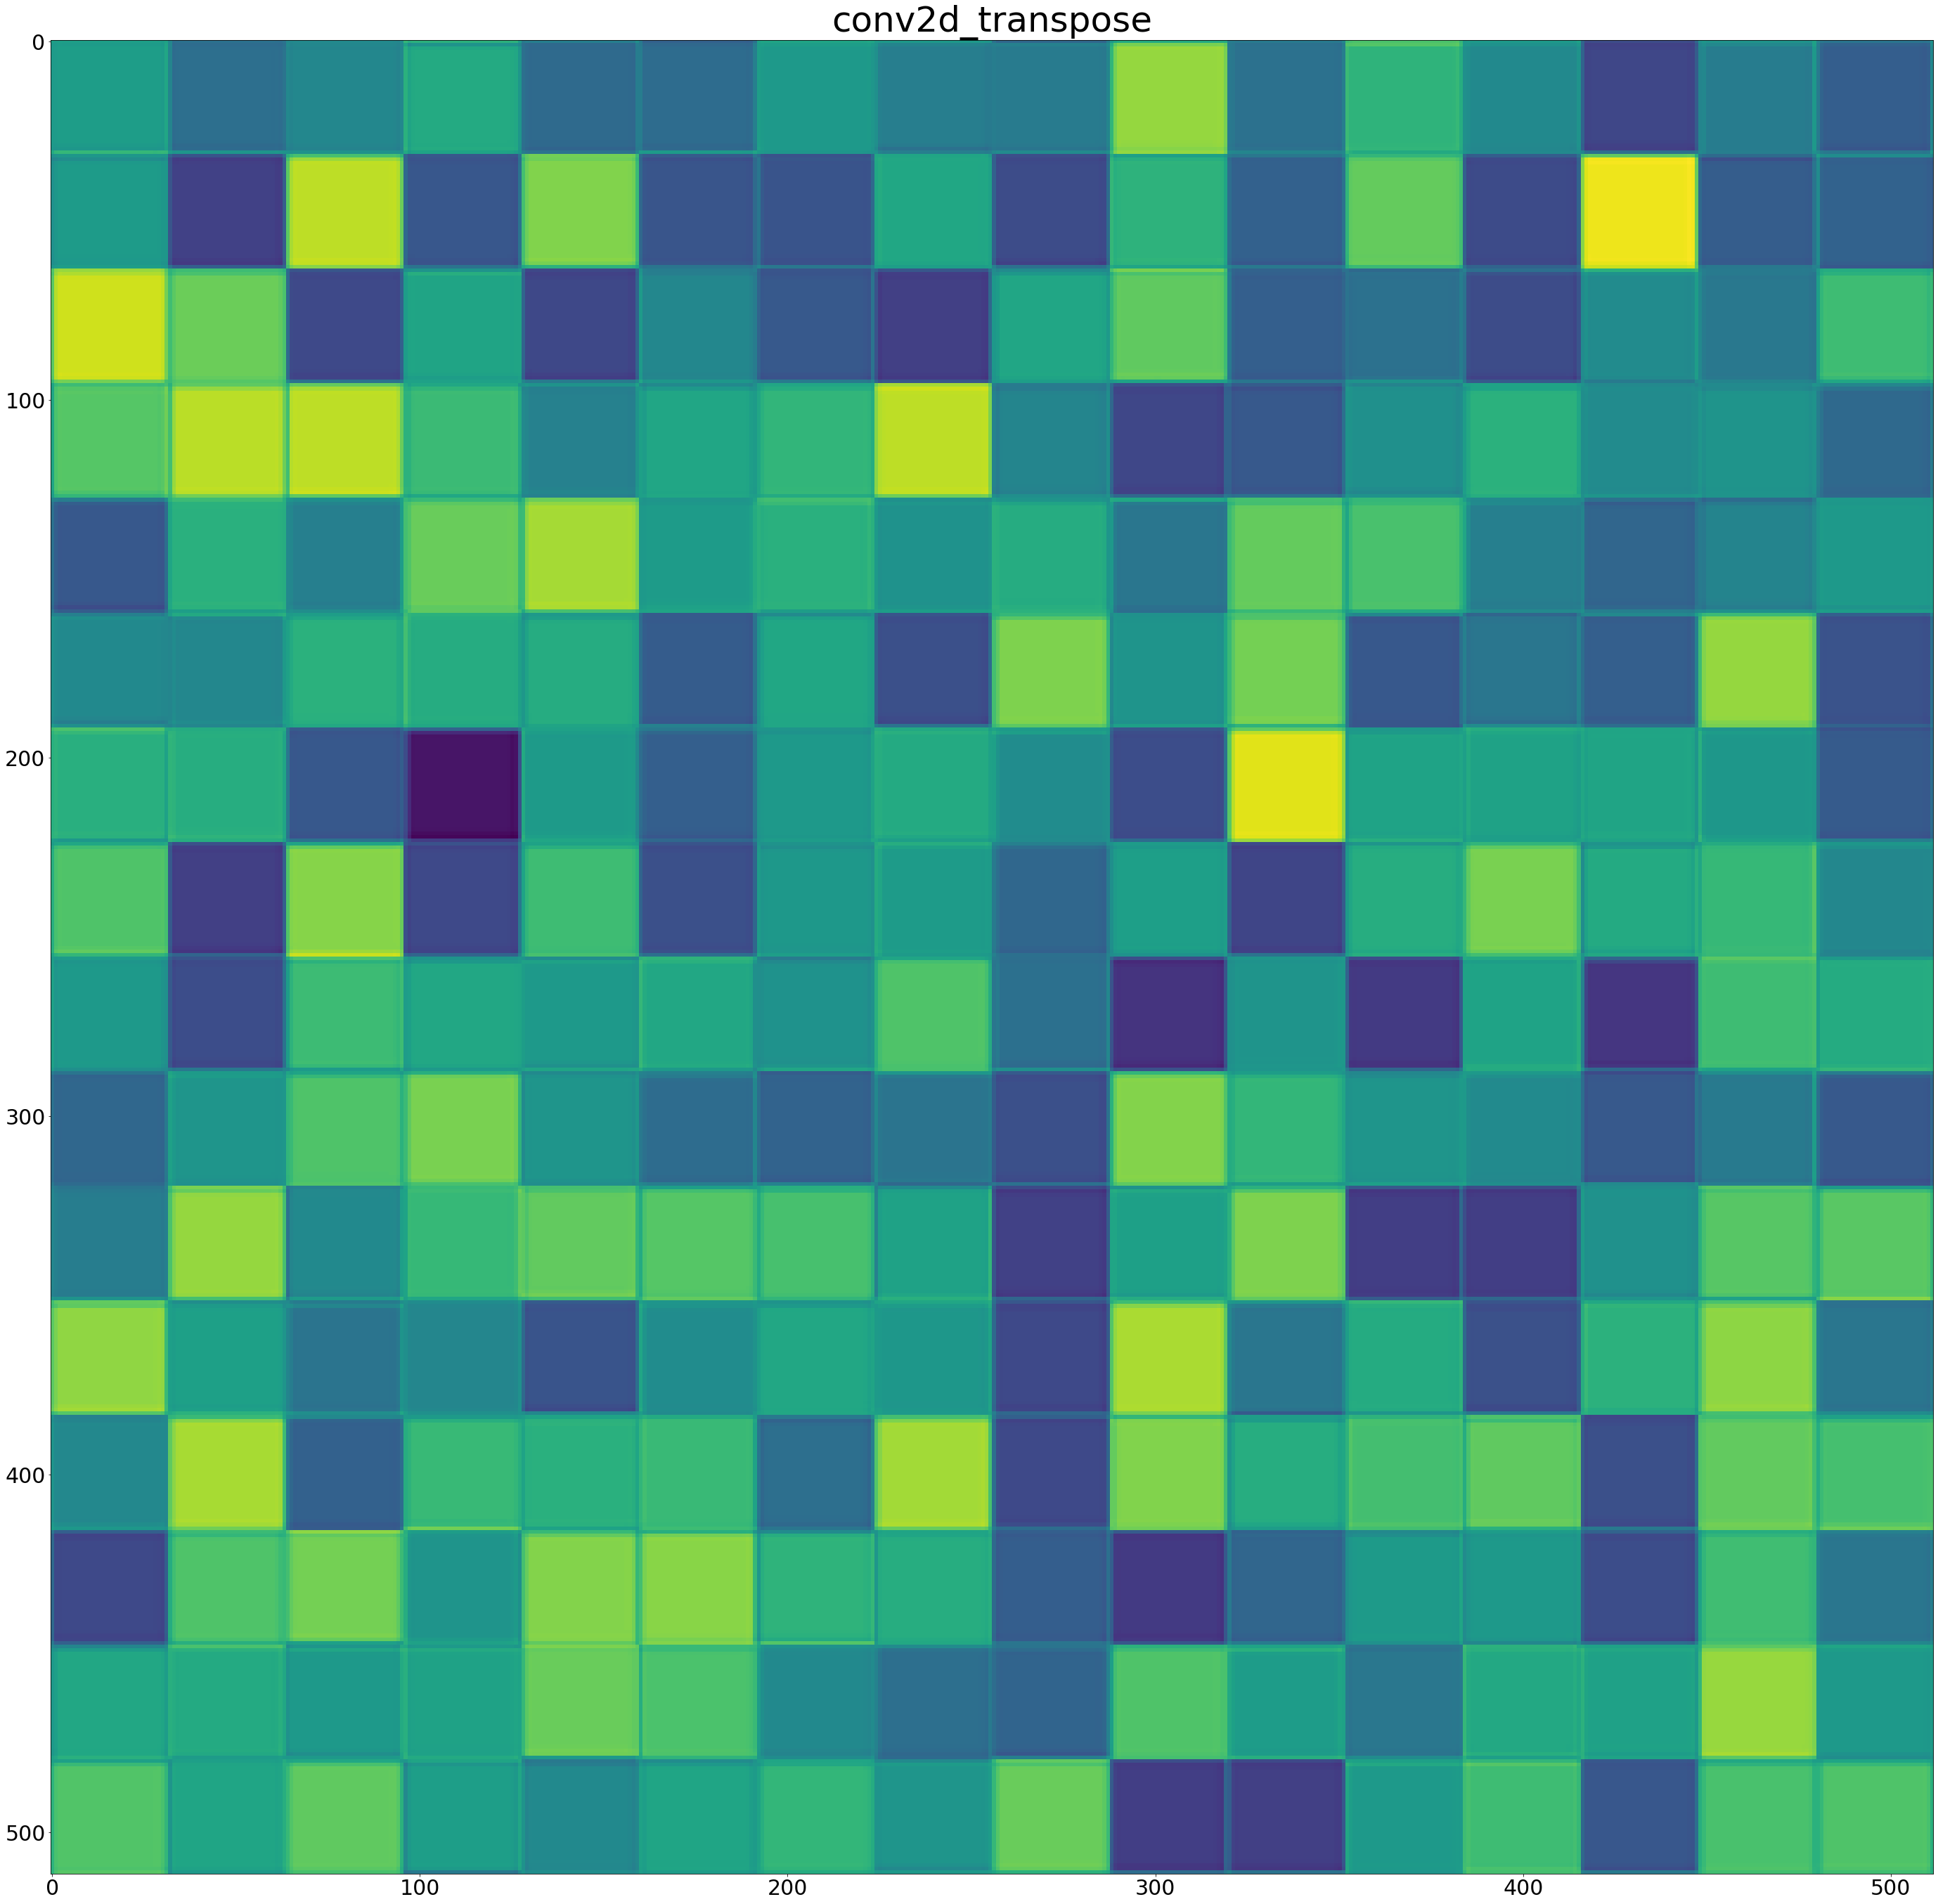

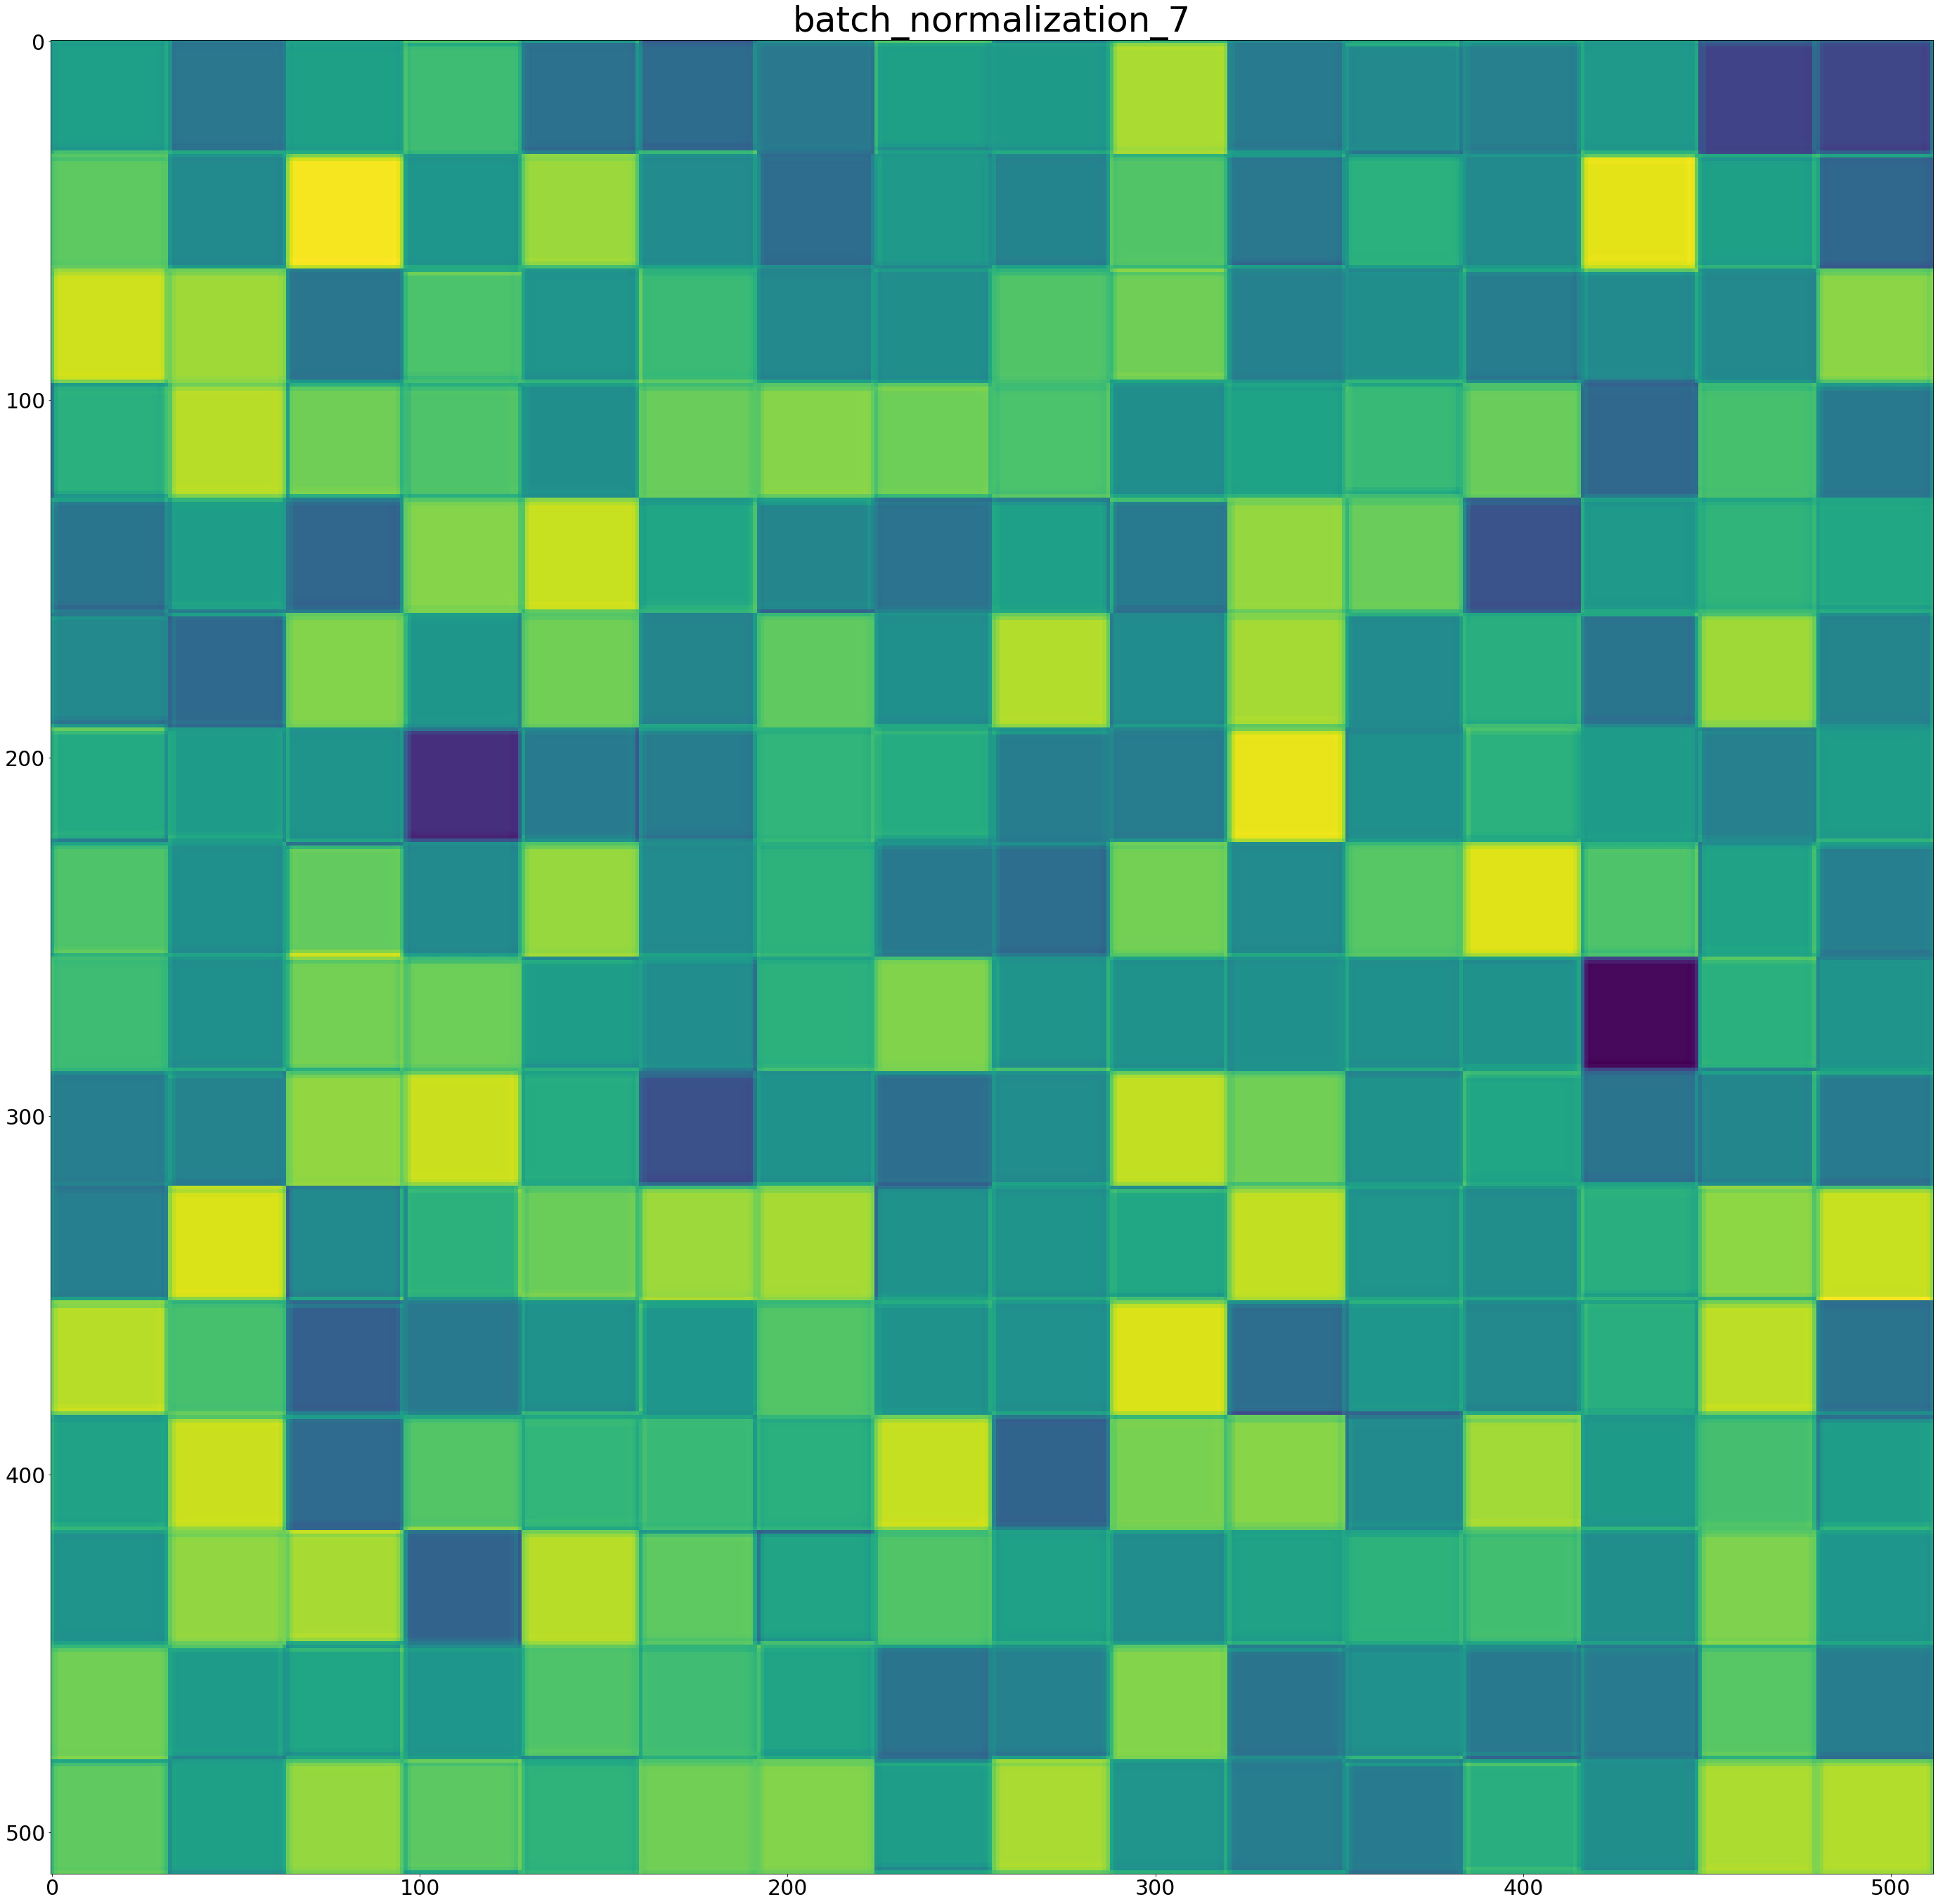

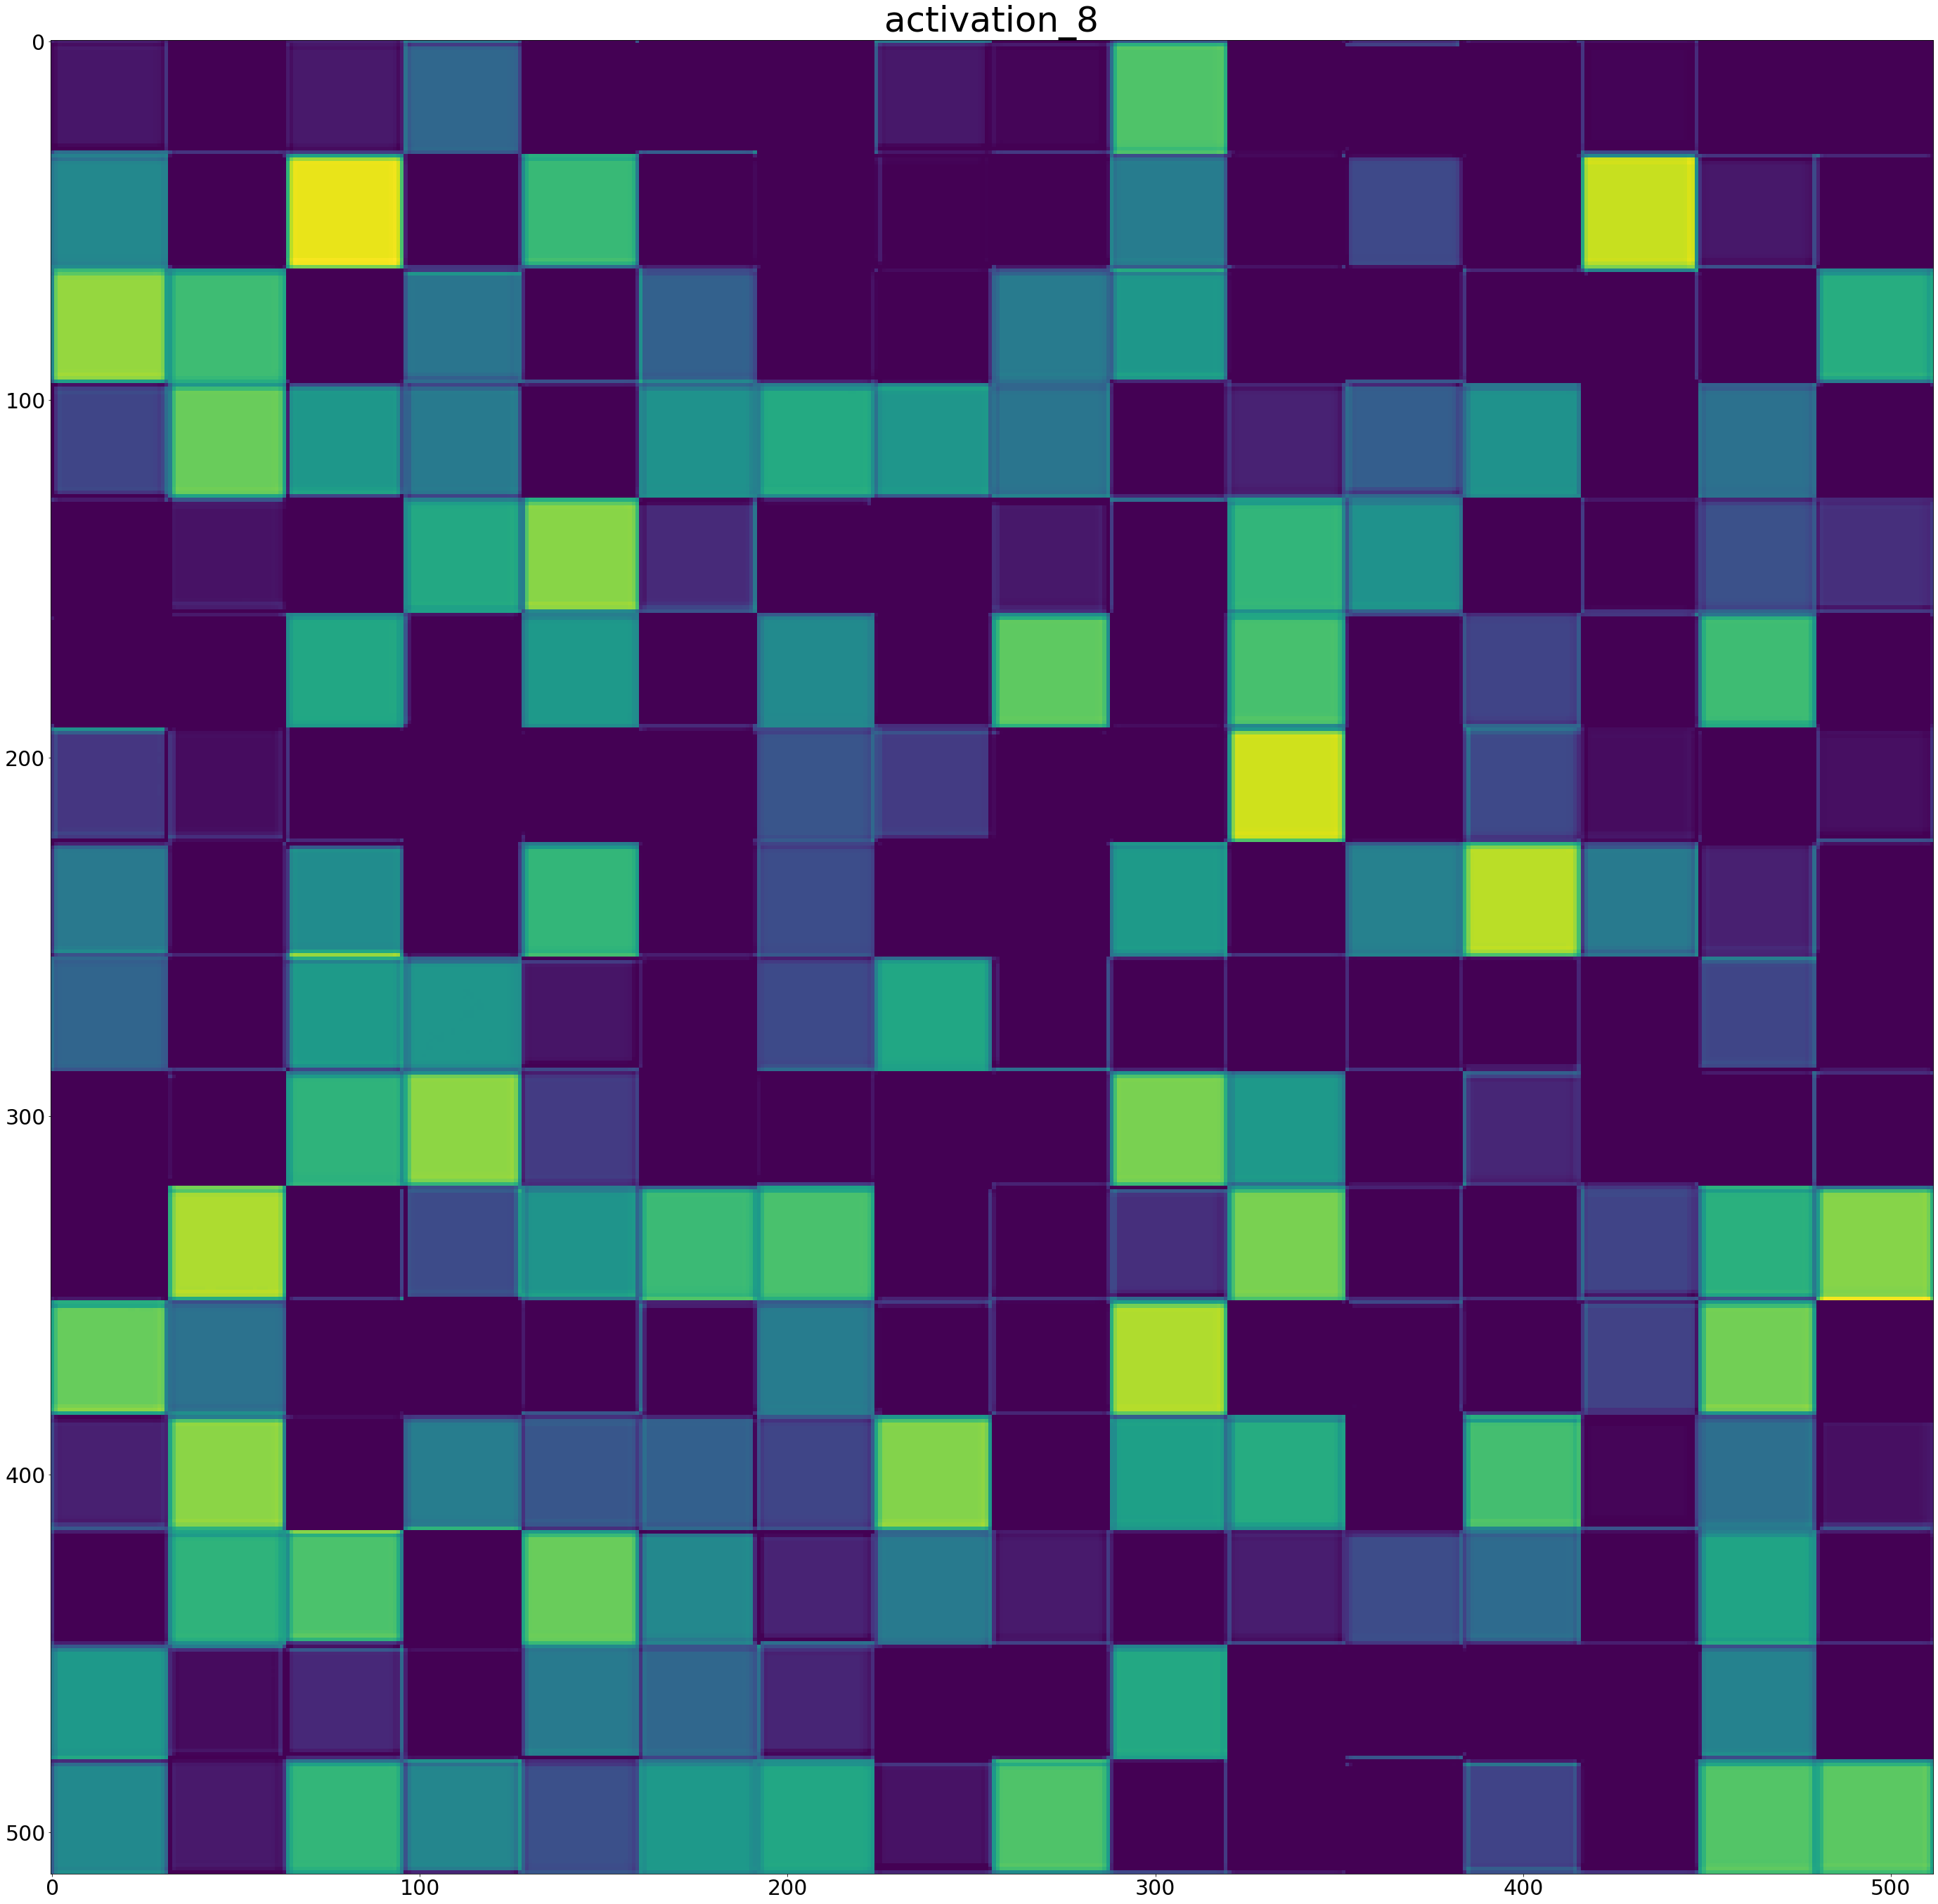

In [125]:
#warnings.filterwarnings(action="ignore" ,category=UserWarning)

# Extracts the outputs starting at x layer
x_layers = 20 #56
x_range = 15
layer_names = []
for layer in activation_model.layers[x_layers:x_layers+x_range]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, temp_pred[x_layers:x_layers+x_range]): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    '''print("\n1~activation_shape " ,layer_activation.shape)
    print("n_features " ,n_features)
    print("size " ,size)
    print("n_cols " ,n_cols)
    print("display_grid " ,size * n_cols ," ; " ,images_per_row * size)
    print("2~layername " ,layer_name)'''
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            '''channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            #channel_image /= channel_image.std()
            channel_image *= 3
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')'''
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 3. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name,fontsize=50)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto' #,cmap='viridis'
              )

#warnings.filterwarnings(action='default')

In [ ]:
#how to overlay 2 channel predictions?

### scratch section

In [169]:
tempxx = np.load(datapath+'/image_file_14.npy')
tempxx = np.load(datapath+'/label_file_14.npy')
tempxx.shape

(32, 512, 512, 1)

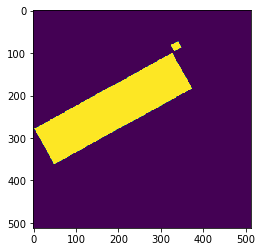

In [213]:
plt.imshow(tempxx[0,:,:,0])

<function matplotlib.pyplot.show(*args, **kw)>

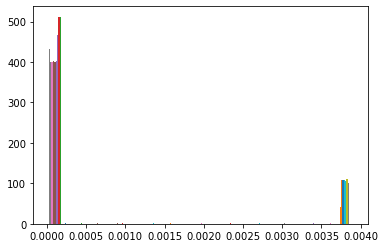

In [228]:
tempxx = np.load(datapath+'/label_file_14.npy')
rng = tempxx[0,:,:,0]
plt.hist(rng, bins='auto')
plt.show

In [222]:

unique_elements, counts_elements = np.unique((tempxx[0,:,:,0]) ,return_counts=True)
print(np.asarray((tempxx[0,:,:,0], counts_elements)))
print("\nFrequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 array([225776,      1,      1, ...,      1,      1,  35346])]

Frequency of unique values of the said array:
[[0.00000000e+00 7.20379512e-06 8.93098240e-06 ... 3.91766243e-03
  3.91986361e-03 3.92156886e-03]
 [2.25776000e+05 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 3.53460000e+04]]


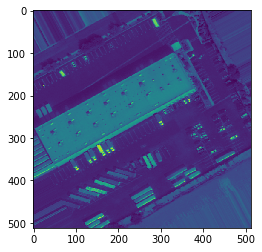

In [168]:
plt.imshow(tempxx[0,:,:,0])

In [ ]:
def Printthis(df ,ind=False ,elems=5 ,rows=10 ,columns=None ,rand=False ,prt=False):
    if prt == True:
        with pd.option_context('display.max_rows', None
                               , 'display.max_columns', None
                               ,'display.width', None
                              ,'display.max_colwidth', None):
            print (df)
    else:
        size = len(df)

        if ind==True:
            return index
        elif rand == False:
            with pd.option_context('display.max_rows', rows
                                   , 'display.max_columns', columns
                                   ,'display.width', None
                                  ,'display.max_colwidth', None):
                print (df.iloc[:rows])
        else:
            index = np.random.permutation(size)[:elems]
            with pd.option_context('display.max_rows', rows
                                   , 'display.max_columns', columns
                                   ,'display.width', None
                                  ,'display.max_colwidth', None):
                print (df.iloc[index])